In [2]:
!pip install refractio[snowflake]
!pip install scikit-learn 
!pip install matplotlib
!pip install statsmodels
!pip install pmdarima
!pip install fosforml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 116.2 MB/s eta 0:00:0000:01
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.2
    Uninstalling urllib3-2.2.2:
      Successfully uninstalled urllib3-2.2.2
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 4.2.2
    Uninstalling platformdirs-4.2.2:
      Successfully uninstalled platformdirs-4.2.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.0
    Uninstalling pandas-2.2.0:
      Successfully uninstalled pandas-2.2.0
  Attempting uninstall: cryptography
    Found existing installation: cryptography 42.0.5
    Uninstalling cryptography-42.0.5:
      Successfully uninstalled cryptography-42.0.5
  Attempting unins

In [3]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


## Step 1. Connecting to the Snowflake Connection specified in Insight Designer Module

In [1]:
from fosforml.model_manager.snowflakesession import get_session
my_session = get_session()

### (i) Getting dataset from Insight Designer

In [2]:
table_name = 'PHARMACEUTICAL_BRAND'

In [3]:
table_name

'PHARMACEUTICAL_BRAND'

In [4]:
sf_df = my_session.sql("select * from {}".format(table_name))
dataset = sf_df.to_pandas()

## Step 2. Exploratory Data Analysis (EDA)

## Checking TRx trend for GAMMATEX brand
## Plot shows various highs and lows but yearly essence of TRx shows an upward trend.

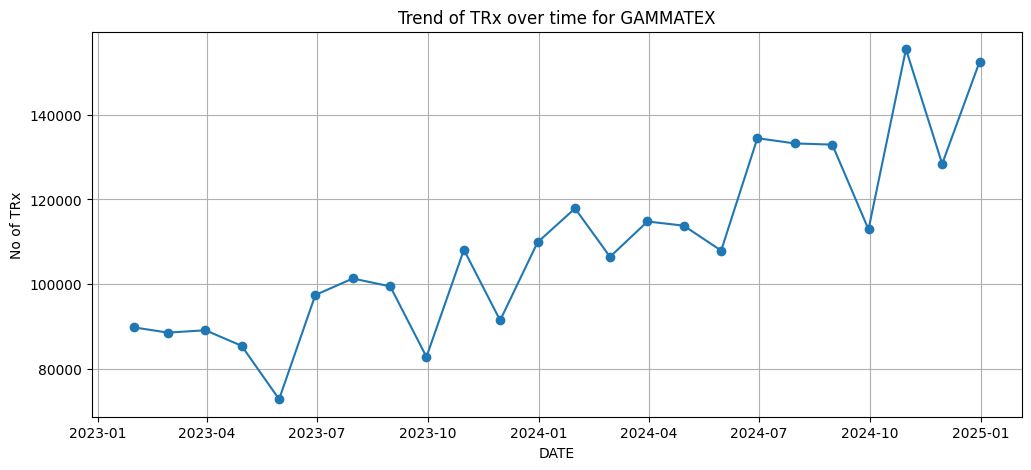

In [5]:
import matplotlib.pyplot as plt #importing pandas and matplotlib library.
import pandas as pd
gammatex_data = dataset[dataset['BRAND']=='GAMMATEX'] #to read the dataset where brand is GAMMATEX
gammatex_data.loc[:,'DATE'] = pd.to_datetime(gammatex_data.loc[:,'DATE']) #To DATETIME format conversion for python to understand
monthly_data = gammatex_data.resample('M', on='DATE').sum() #Aggregation of data to Monthly data by adding all values. 
plt.figure(figsize = (12,5)) #visualisation
plt.plot(monthly_data.index , monthly_data['TRX'],  marker='o',  linestyle = '-')
plt.title('Trend of TRx over time for GAMMATEX')
plt.xlabel('DATE')
plt.ylabel('No of TRx')
plt.grid(True)
plt.show()

## Checking TRx trend for DELTAZYME brand
## Plot shows various highs and lows but yearly essence of TRx shows an downward trend.

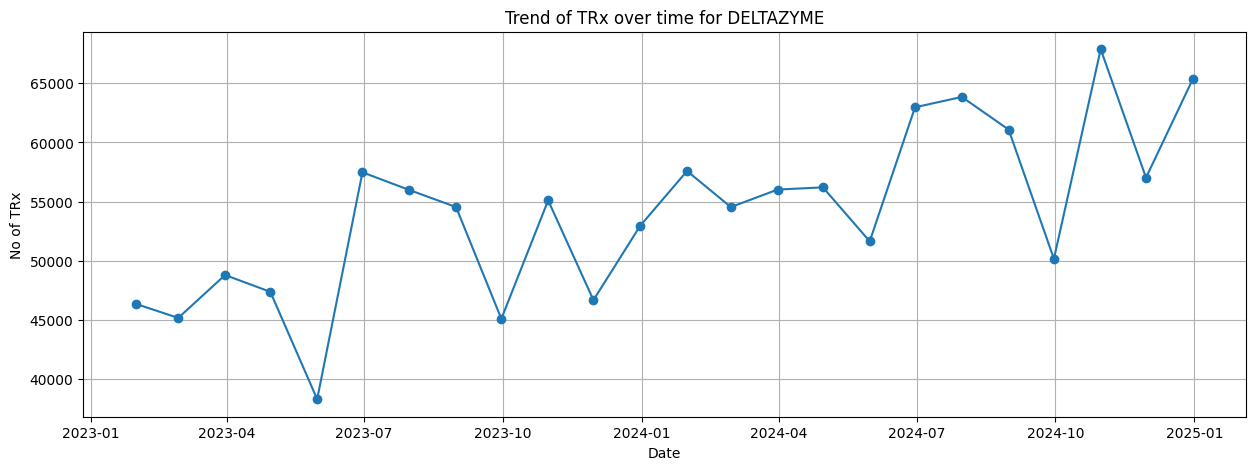

In [6]:
import matplotlib.pyplot as plt
deltazyme_data = dataset[dataset['BRAND']=='DELTAZYME']
deltazyme_data.loc[:,'DATE'] = pd.to_datetime(deltazyme_data.loc[:,'DATE'])
monthly_data = deltazyme_data.resample('M', on='DATE').sum()
plt.figure(figsize = (15,5))
plt.plot(monthly_data.index , monthly_data['TRX'],  marker='o',  linestyle = '-')
plt.title('Trend of TRx over time for DELTAZYME')
plt.xlabel('Date')
plt.ylabel('No of TRx')
plt.grid(True)
plt.show()

## Exploring the region-wise trends for all the brands

## Total Prescriptions were added after grouping them by brand and region wise. We came up with a list of unique Brands (4) and unique Regions (7) to Plot the trends which include 28 Subplots

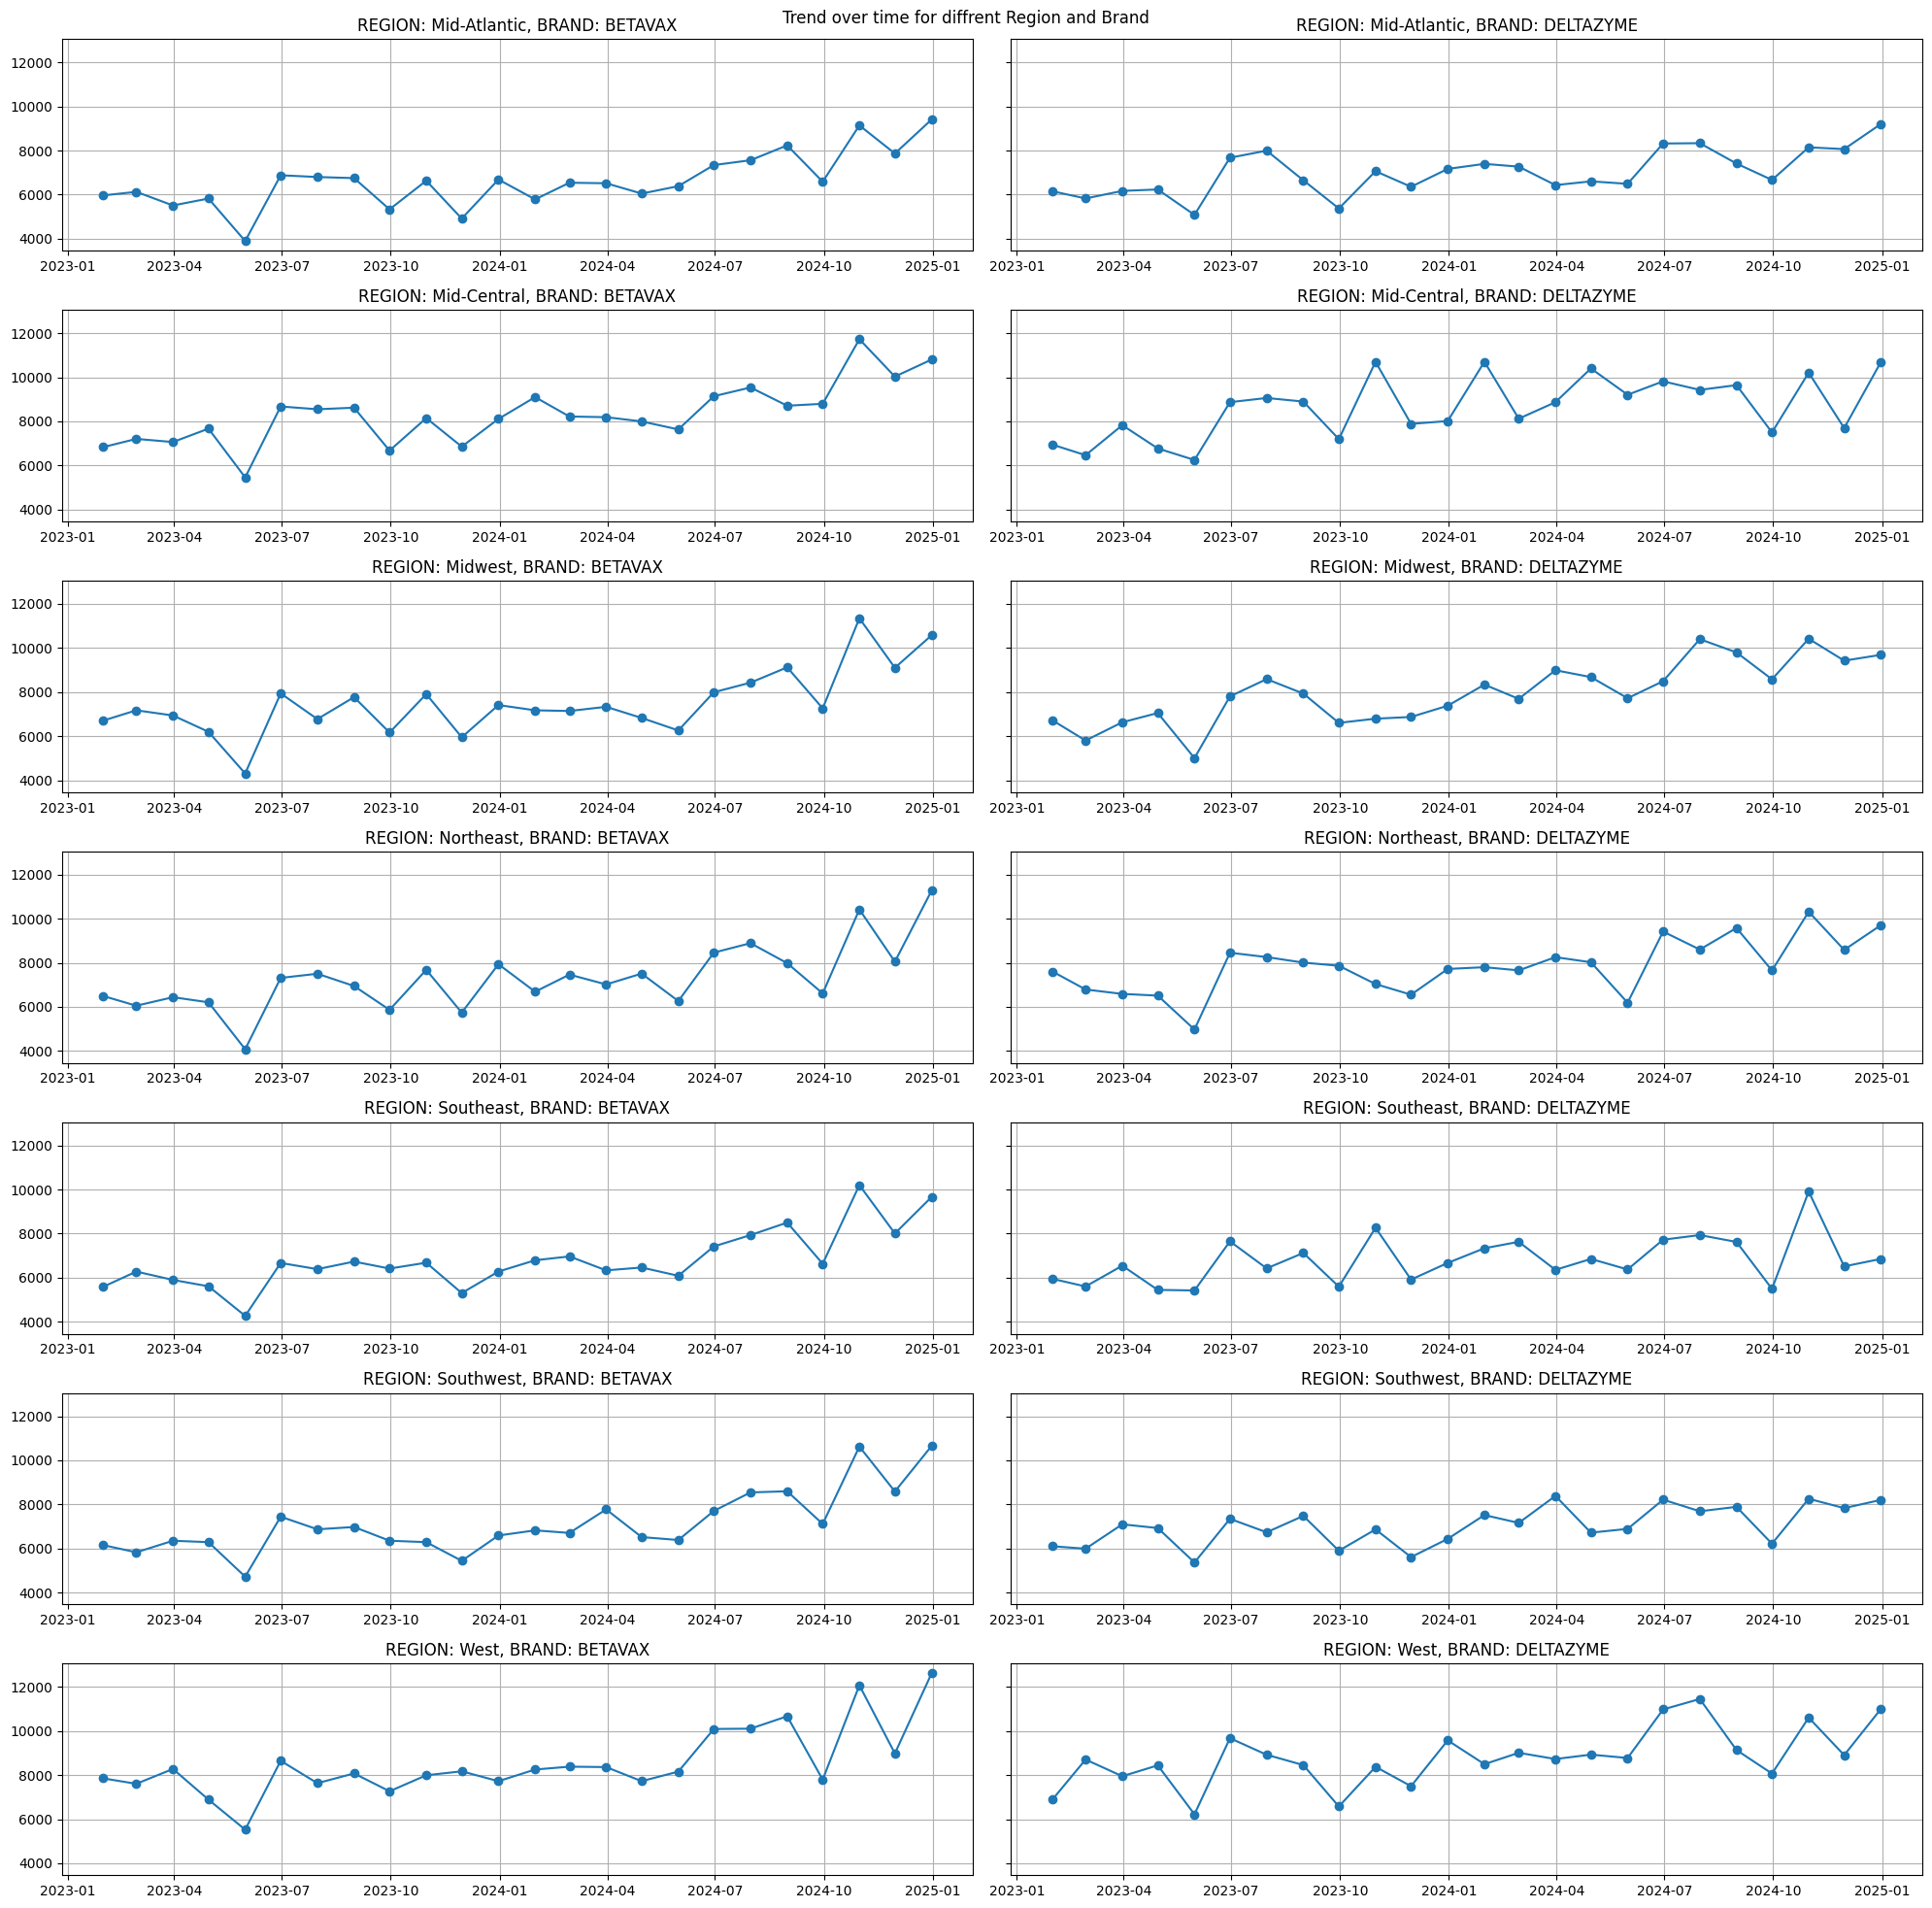

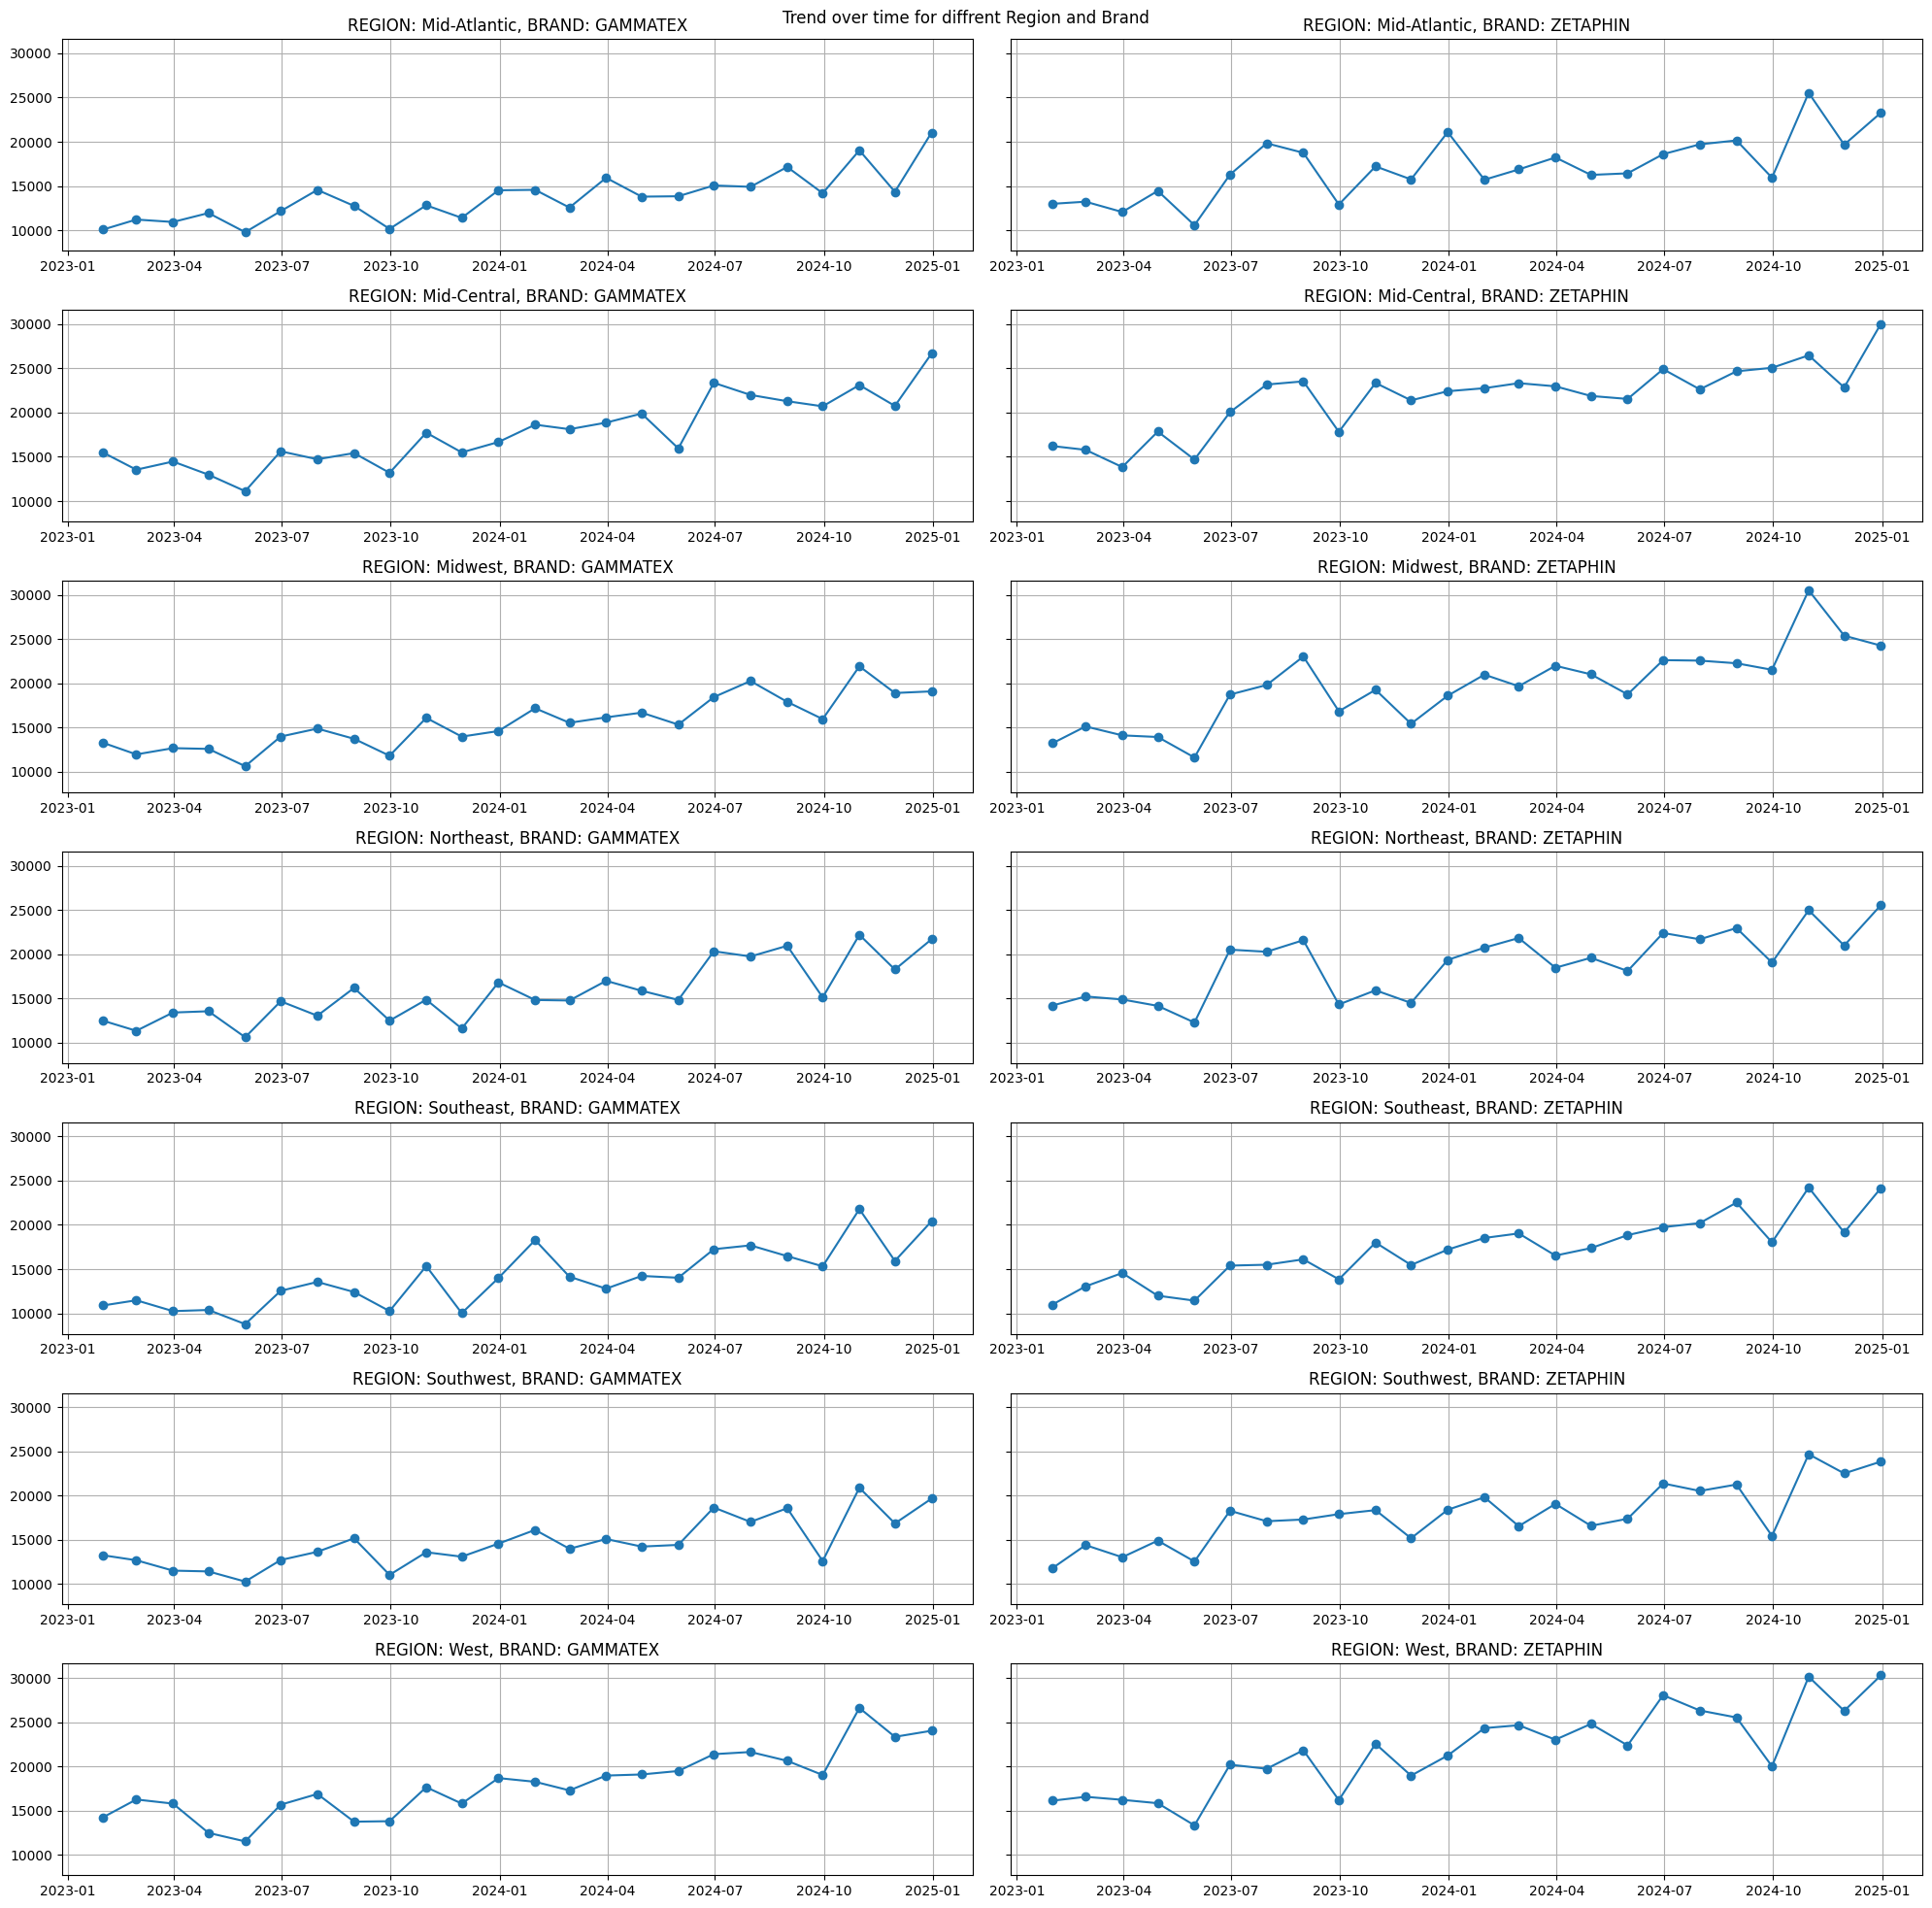

In [7]:
dataset['DATE'] = pd.to_datetime(dataset['DATE'])
grouped_data = dataset.groupby(['BRAND' , 'REGION', pd.Grouper(key = 'DATE', freq= 'M')]).sum().reset_index()
region_list = grouped_data['REGION'].unique()
brand_list = grouped_data['BRAND'].unique()
fig1,axs1 = plt.subplots(len(region_list), 2 , figsize = (20,20), sharey=True)
fig1.suptitle('Trend over time for diffrent Region and Brand')

for i, region in enumerate(region_list):
    for j, brand in enumerate(brand_list[:2]):
        region_brand_data = grouped_data[(grouped_data['REGION']== region) & (grouped_data['BRAND'] == brand)]
        axs1[i,j].plot(region_brand_data['DATE'], region_brand_data['TRX'] , marker='o' , linestyle='-')
        axs1[i,j].set_title(f'REGION: {region}, BRAND: {brand}')
        axs1[i,j].set_xlable = ('Time')
        axs1[i,j].set_ylable = ('No of TRx')
        axs1[i,j].grid(True)
plt.tight_layout()
plt.show()
fig2,axs2 = plt.subplots(len(region_list), 2 , figsize = (20,20), sharey=True)
fig2.suptitle('Trend over time for diffrent Region and Brand')
for i, region in enumerate(region_list):
    for j, brand in enumerate(brand_list[2:]):
        region_brand_data = grouped_data[(grouped_data['REGION']== region) & (grouped_data['BRAND'] == brand)]
        axs2[i,j].plot(region_brand_data['DATE'], region_brand_data['TRX'] , marker='o' , linestyle='-')
        axs2[i,j].set_title(f'REGION: {region}, BRAND: {brand}')
        axs2[i,j].set_xlable = ('Time')
        axs2[i,j].set_ylable = ('No of TRx')
        axs2[i,j].grid(True)
plt.tight_layout()
plt.show()

#### Observation: In above plots we have seen little Upward , Downward as well as Sideways trend. But there is no high upsurge or downsurge can be seen in any brand. 

# Step 3. Start Analysing different Models that can be used in Forecasting future trends.

#### We have selected GAMMATEX brand and Mid-Atlantic region to do further modeling analysis.

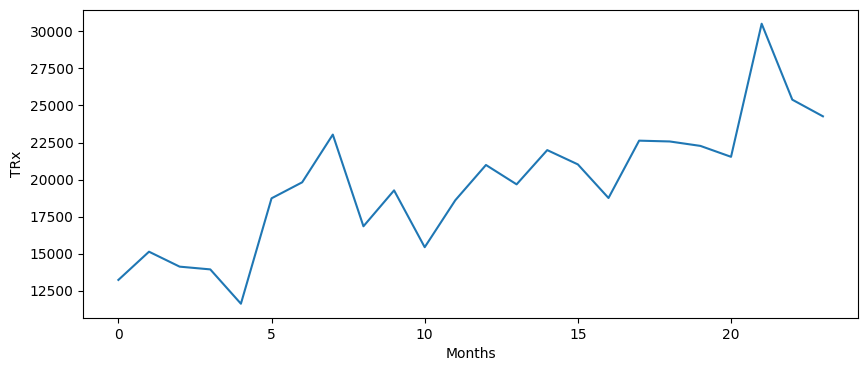

In [8]:
zetaphin_midwest_data = grouped_data[(grouped_data['BRAND']  == 'ZETAPHIN') & (grouped_data['REGION'] == 'Midwest')]
final_dataset = zetaphin_midwest_data[['DATE','TRX']].reset_index(drop = True)
final_dataset['Month'] = final_dataset.index+1
plt.figure(figsize=(10,4))
plt.xlabel("Months")
plt.ylabel("TRx")
plt.plot(final_dataset['TRX'])

# Decomposing time series data into seasonal and trend component.
### Time series decomposition helps us break down a time series dataset into three main components:
-  __Trend:__ The trend component represents the long-term movement in the data, representing the underlying pattern.
-  __Seasonality:__ The seasonality component represents the repeating, short-term fluctuations caused by factors like seasons or cycles.
-  __Residual (Noise):__ The residual component represents random variability that remains after removing the trend and seasonality.
    <br><br> By separating these components, we can gain insights into the behavior of the data and make better forecasts.
    
<br><br> __Types of Time Series Decomposition Techniques__
-  __Additive Decomposition:__ <br>

In additive decomposition, the time series is expressed as the sum of its components: <br> $ Y(t) = Trend(t) + Seasonal(t) + Residual(t) $
<br> It’s suitable when the magnitude of seasonality doesn’t vary with the magnitude of the time series.

-  __Multiplicative Decomposition:__<br>

In multiplicative decomposition, the time series is expressed as the product of its components: <br> $Y(t) = Trend(t) * Seasonal(t) * Residual(t)$ 
<br> It’s suitable when the magnitude of seasonality scales with the magnitude of the time series.

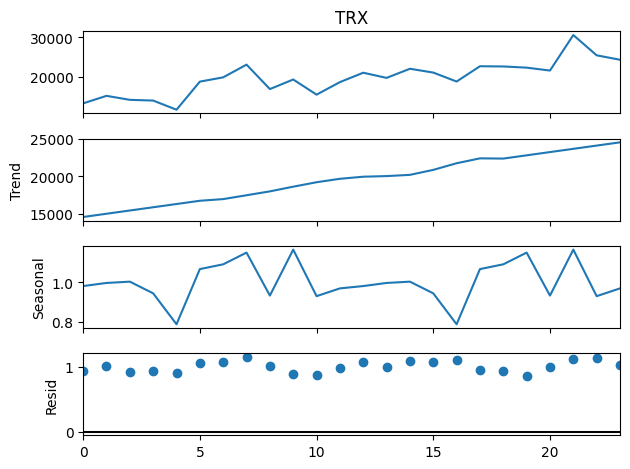

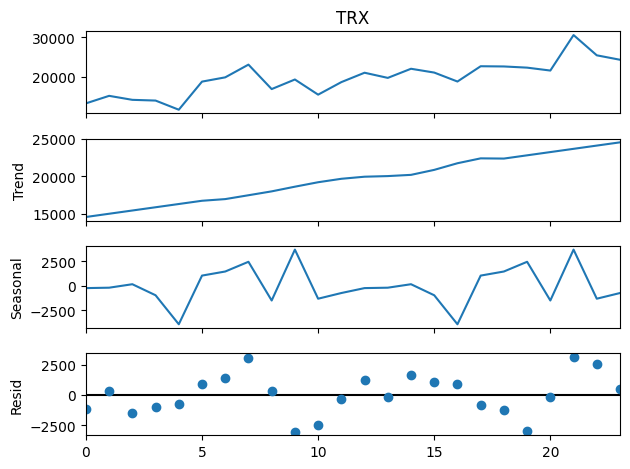

In [9]:
# Decomposing Time series

from statsmodels.tsa.seasonal import seasonal_decompose
ts_decompose_multiplicative = seasonal_decompose(final_dataset['TRX'], model = 'multiplicative', period=12, extrapolate_trend = 'freq')
ts_decompose_additive = seasonal_decompose(final_dataset['TRX'], model = 'additive', period=12, extrapolate_trend = 'freq')
#Plotting 
#ts_decompose.show()
ts_plot = ts_decompose_multiplicative.plot()
ts_plot = ts_decompose_additive.plot()

### Writing seasonal , trend and residual part of multiplicative component back into the dataframe.

In [10]:
import warnings
warnings.filterwarnings("ignore")
df_decomposed = pd.concat([ts_decompose_multiplicative.seasonal, ts_decompose_multiplicative.trend, ts_decompose_multiplicative.resid, ts_decompose_multiplicative.observed], axis = 1)
df_decomposed.columns = ['seasonal', 'trend', 'residual', 'actual_values']
final_dataset.loc[:,'seasonal'] = df_decomposed.loc[:,'seasonal']
final_dataset.loc[:,'trend'] = df_decomposed.loc[:,'trend']
final_dataset.loc[:,'residual'] = df_decomposed.loc[:,'residual']

## Start Exploring Different Methods for Time Series Analysis.
1. __Moving Average:__ <br>
In time series analysis, the moving-average model (MA model), also known as moving-average process, is a common approach for modeling __univariate time series__. <br>
This model smoothens the time series curve by computing the __average__ of all the data points in a fixed-width sliding window and replacing those points with the computed value.

In [11]:
import warnings
warnings.filterwarnings("ignore")
final_dataset.loc[:,'MAvg_12']= final_dataset.loc[:,'TRX'].rolling(window = 12).mean().shift(1)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
final_dataset[['TRX', 'MAvg_12']][12:]

,TRX,MAvg_12
12,20983.00,16647.17
13,19676.00,17293.67
14,21987.00,17672.50
15,21023.00,18328.00
16,18755.00,18918.58
17,22625.00,19513.25
18,22570.00,19837.58
19,22271.00,20067.25
20,21534.00,20003.67
21,30517.00,20394.42


#### To see the comparison between actual TRx vs the average of these data points replaced by Moving Average Model

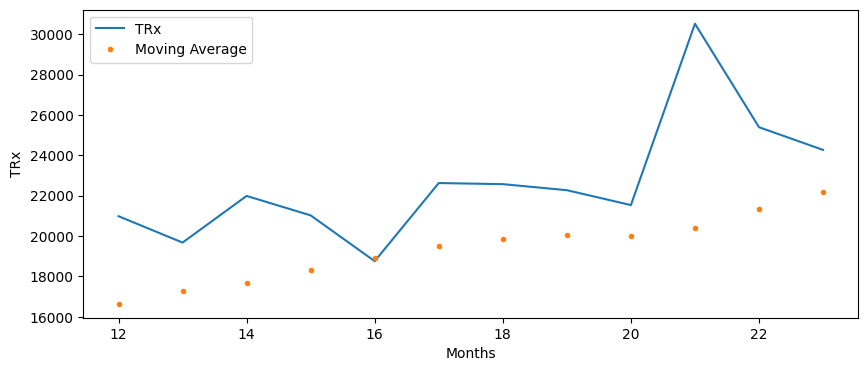

In [12]:
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(10,4))
plt.xlabel("Months")
plt.ylabel("TRx")
plt.plot(final_dataset['TRX'][12:])
plt.plot(final_dataset['MAvg_12'][12:], '.')
plt.legend(['TRx','Moving Average'])

#### To check the accuracy of varios forecasting model , few Accuracy Metrics has to be defined.
-  __MAE:__ <br> Mean Absoulute Error MAE is defined as the average of absolute difference between forecasted values and true values.
-  __MAPE:__ <br> The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in statistics ,  indicating the average deviation between forecasted and actual values. <br> 
    $  ([( | actual - forecast | ) / | actual | ] * 100) $
-  __MSE:__ <br> (Mean Squared Error) It is also defined as the metric that assesses the quality of forecasting model or predictor. MSE also incorporates both the variance (the spread of predicted values from each other) and bias (the distance of predicted value from its true value). <br> 
-  __RMSE:__ <br> Root Mean Squared Error ,this metric is an extension of MSE and is defined as the square root of mean square error.

In [13]:
# Defining Mape Function
import numpy as np
def get_mape(actual, predicted):
    y_true , y_pred = np.array(actual) , np.array(predicted)
    return np.round(np.mean(np.abs((y_true-y_pred)/y_true))*100, 2)

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mae_mavg = mean_absolute_error(final_dataset['TRX'][12:].values , final_dataset['MAvg_12'][12:].values)
mse_mavg = mean_squared_error(final_dataset['TRX'][12:].values , final_dataset['MAvg_12'][12:].values)
mape_mavg = get_mape(final_dataset['TRX'][12:].values , final_dataset['MAvg_12'][12:].values)
rmse_mavg = np.sqrt(mse_mavg)
print('Mape error in moving average is', mape_mavg , '%.')
print('Mean Absoulte Error in moving average is', mae_mavg )
print('Mean Squared Error in moving average is', mse_mavg )
print('Root Mean Squared Error in moving average is', rmse_mavg )

Mape error in moving average is 13.9 %.
Mean Absoulte Error in moving average is 3313.069444444444
Mean Squared Error in moving average is 16508709.565972218
Root Mean Squared Error in moving average is 4063.09113434245


2. __Exponential smoothing:__ <br>
Exponential smoothing is a broadly accurate forecasting method for short-term forecasts. The technique assigns larger weights to more recent observations while assigning exponentially decreasing weights as the observations get increasingly distant. <br>
This methods work on the principle that a prediction is a weighted linear sum of past observations or lags.

In [15]:
#Exponential Smoothing
final_dataset.loc[:,'EWM'] = final_dataset.loc[:,'TRX'].ewm(alpha = 0.2).mean()
final_dataset[12:]

,DATE,TRX,Month,seasonal,trend,residual,MAvg_12,EWM
12,2024-01-31,20983.00,13,0.98,19952.42,1.07,16647.17,18354.24
13,2024-02-29,19676.00,14,1.00,20035.46,0.99,17293.67,18630.75
14,2024-03-31,21987.00,15,1.00,20199.04,1.09,17672.50,19326.48
15,2024-04-30,21023.00,16,0.94,20863.08,1.07,18328.00,19675.61
16,2024-05-31,18755.00,17,0.79,21746.62,1.09,18918.58,19487.25
17,2024-06-30,22625.00,18,1.06,22397.38,0.95,19513.25,20126.31
18,2024-07-31,22570.00,19,1.09,22368.71,0.93,19837.58,20622.19
19,2024-08-31,22271.00,20,1.15,22801.05,0.85,20067.25,20955.80
20,2024-09-30,21534.00,21,0.93,23233.40,0.99,20003.67,21072.52
21,2024-10-31,30517.00,22,1.16,23665.75,1.11,20394.42,22975.46


### Comparison between Exponential smoothing and Moving Average models
Exponential smoothing performs better because it took weighted sum of data points.

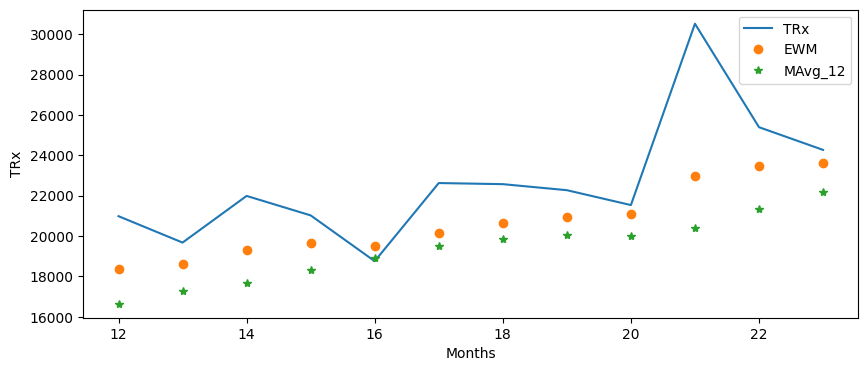

In [16]:
plt.figure(figsize=(10,4))
plt.xlabel("Months")
plt.ylabel("TRx")
plt.plot(final_dataset['TRX'][12:])
plt.plot(final_dataset['EWM'][12:], 'o')
plt.plot(final_dataset['MAvg_12'][12:], '*')
plt.legend(['TRx','EWM','MAvg_12'])

In [17]:
mae_ewm = mean_absolute_error(final_dataset['TRX'][12:].values , final_dataset['EWM'][12:].values)
mse_ewm = mean_squared_error(final_dataset['TRX'][12:].values , final_dataset['EWM'][12:].values)
mape_ewm = get_mape(final_dataset['TRX'][12:].values , final_dataset['EWM'][12:].values)
rmse_ewm = np.sqrt(mse_ewm)
print('Mape = ', mape_ewm , '%.')
print('MAE = ', mae_ewm )
print('MSE = ', mse_ewm )
print('RMSE = ', rmse_ewm )

print('Error reduced by', (mape_mavg-mape_ewm)*100/mape_mavg , '%')

Mape =  8.58 %.
MAE =  2062.679291693565
MSE =  7535462.387671425
RMSE =  2745.079668729384
Error reduced by 38.273381294964025 %


__3. ARIMA Model__<br>
An autoregressive integrated moving average model is a form of regression analysis that gauges the strength of one dependent variable relative to other changing variables. The model's goal is to predict future securities or financial market moves by examining the differences between values in the series instead of through actual values.

<br> An ARIMA model can be understood by outlining each of its components as follows:<br>

-  __Autoregression (AR)__: refers to a model that shows a changing variable that regresses on its own lagged, or prior, values.<br>
-  __Integrated (I):__ represents the differencing of raw observations to allow the time series to become stationary (i.e., data values are replaced by the difference between the data values and the previous values).<br>
-  __Moving average (MA):__  incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations.

__ARIMA Parameters__<br>
Each component in ARIMA functions as a parameter with a standard notation. For ARIMA models, a standard notation would be ARIMA with p, d, and q, where integer values substitute for the parameters to indicate the type of ARIMA model used. The parameters can be defined as:
1<br>

-  __p:__ the number of lag observations in the model, also known as the lag order.<br>
-  __d:__ the number of times the raw observations are differenced; also known as the degree of differencing.<br>
-  __q:__ the size of the moving average window, also known as the order of the moving average.

#### Autocorrelation Function and Partial Autocorrelation Function
__Autocorrelation Function (ACF):__<br>
Correlation between time series with a lagged version of itself. The correlation between the observation at the current time spot and the observations at previous time spots.The autocorrelation function starts a lag 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.

__Partial Autocorrelation Function (PACF):__<br>
Additional correlation explained by each successive lagged term. The correlation between pbservations at two time spots given that we consider both observations are correlated to observations at other time spots.

<br> The partial autocorrelation at lag k is the autocorrelation between 
X(t) and X(t−k) that is not accounted for by lags 1 through k−1.

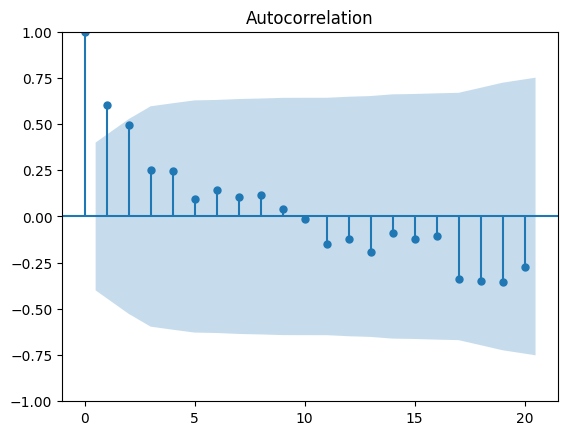

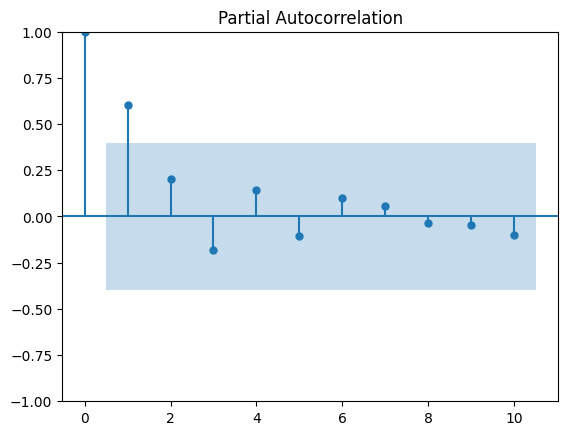

In [18]:
#To identify the value of lag(p)
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf

acf_plot = plot_acf(final_dataset.TRX, lags =20)
pacf_plot = plot_pacf(final_dataset.TRX , lags =10)

In [19]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
arima_model_1 = ARIMA(final_dataset['TRX'][0:12], order=(1,0,0)) #first 1 AR-autoregression (p), Last 0 Moving Avg (q), Middle (d) 0 - Integration 1,1,1 Integratiive auto regression moving average
ar_model_1 = arima_model_1.fit()
ar_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    TRX   No. Observations:                   12
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -112.931
Date:                Wed, 11 Dec 2024   AIC                            231.862
Time:                        09:09:18   BIC                            233.316
Sample:                             0   HQIC                           231.323
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.665e+04   1378.203     12.079      0.000    1.39e+04    1.93e+04
ar.L1          0.3668      0.281      1.305      0.192      -0.184       0.918
sigma2      8.502e+06   6.74e+06      1.261      0.207   -4.71e+06    2.17e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 1.06
Prob(Q):                              0.72   Prob(JB):                         0.59
Heteroskedasticity (H):               1.25   Skew:                             0.30
Prob(H) (two-sided):                  0.83   Kurtosis:                         1.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
forecast_ar_1 = ar_model_1.predict(12,18)
mape_ar_1 = get_mape(final_dataset['TRX'][12:19], forecast_ar_1)
mae_ar_1 = mean_absolute_error(final_dataset['TRX'][12:19].values , forecast_ar_1)
mse_ar_1 = mean_squared_error(final_dataset['TRX'][12:19].values , forecast_ar_1)
mape_ar_1 = get_mape(final_dataset['TRX'][12:19].values , forecast_ar_1)
rmse_ar_1 = np.sqrt(mse_ar_1)
print('Mape error in Auto Regressive model with lag = 1  is', mape_ar_1 , '%.')
print('MAE = ', mae_ar_1 )
print('MSE = ', mse_ar_1 )
print('RMSE = ', rmse_ar_1 )

Mape error in Auto Regressive model with lag = 1  is 19.94 %.
MAE =  4279.279955867338
MSE =  20312181.613274846
RMSE =  4506.903772355789


In [21]:
#ARMA where (p,d,q) where q = 1 , p=0
arima_2 = ARIMA(final_dataset['TRX'][0:12], order=(0,0,1))
arma_model_2 = arima_2.fit()
forecast_arma_2 = arma_model_2.predict(12,18)
mape_arma_2 = get_mape(final_dataset['TRX'][12:19], forecast_arma_2)
mae_arma_2 = mean_absolute_error(final_dataset['TRX'][12:19].values , forecast_arma_2)
mse_arma_2 = mean_squared_error(final_dataset['TRX'][12:19].values , forecast_arma_2)
mape_arma_2 = get_mape(final_dataset['TRX'][12:19].values , forecast_arma_2)
rmse_arma_2 = np.sqrt(mse_arma_2)
print('Mape error in Auto Regressive Moving Average model with lag = 1  is', mape_arma_2 , '%.')
print('MAE = ', mae_arma_2 )
print('MSE = ', mse_arma_2 )
print('RMSE = ', rmse_arma_2 )

Mape error in Auto Regressive Moving Average model with lag = 1  is 20.39 %.
MAE =  4372.219953528237
MSE =  20990719.74556439
RMSE =  4581.563024292516


In [57]:
#ARMA where (p,d,q) where q = 1 , p=1
arima_3 = ARIMA(final_dataset['TRX'][0:12], order=(1,0,1))
arma_model_3 = arima_3.fit()
forecast_arma_3 = arma_model_3.predict(12,18)
mape_arma_3 = get_mape(final_dataset['TRX'][12:19], forecast_arma_3)
print('Mape error in Auto Regressive Moving Average model with lag = 1  is', mape_arma_3 , '%.')

Mape error in Auto Regressive Moving Average model with lag = 1  is 19.81 %.


In [58]:
#ARIMA where (p,d,q) where q = 1 , p=1 , d=1
arima_4 = ARIMA(final_dataset['TRX'][0:12], order=(1,1,1))
ar_model_4 = arima_4.fit()
forecast_arima = ar_model_4.predict(12,18)
mape_arma_4 = get_mape(final_dataset['TRX'][12:19], forecast_arima)
print('Mape error in Auto Regressive Integarted Moving Average model with lag = 0  is', mape_arma_4, '%.')

Mape error in Auto Regressive Integarted Moving Average model with lag = 0  is 14.54 %.


### Rolling Statistics 
A __rolling average__ is a great way to visualize how the dataset is trending. As the dataset provides counts by month, a window size of 12 will give us the annual rolling average.

<br> We will also include the __rolling standard deviation__ to see how much the data varies from the rolling average.

In [59]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

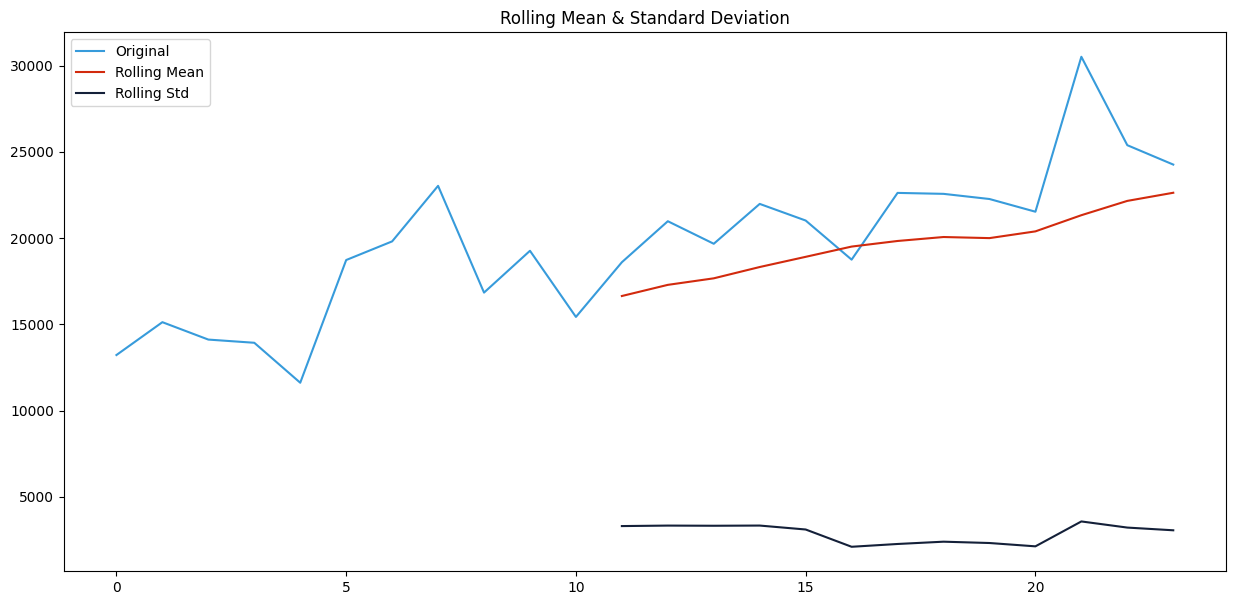

In [60]:
#Determine rolling statistics
final_dataset["rolling_avg"] = final_dataset['TRX'].rolling(window=12).mean() #window size 24 denotes 24 months, giving rolling mean at yearly level
final_dataset["rolling_std"] = final_dataset['TRX'].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(final_dataset['TRX'], color='#379BDB', label='Original')
plt.plot(final_dataset["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(final_dataset["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### Augmented Dickey–Fuller Test
The Augmented Dickey-Fuller Test is used to determine if time-series data is stationary or not. Similar to a t-test, we set a significance level before the test and make conclusions on the hypothesis based on the resulting p-value.
<br>__Null Hypothesis:__ The data is not stationary.
<br>__Alternative Hypothesis:__ The data is stationary.
<br>For the data to be stationary (ie. reject the null hypothesis), the ADF test should have:
p-value <= significance level (0.01, 0.05, 0.10, etc.)
If the p-value is greater than the significance level then we can say that it is likely that the data is not stationary.
<br>We can see in the ADF test below that the __p-value is 1__, meaning that it is very likely that the __data is not stationary.__

In [62]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(final_dataset['TRX'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 1.66
p-value                        1.00
#Lags Used                     7.00
Number of Observations Used   16.00
Critical Value (1%)           -3.92
Critical Value (5%)           -3.07
Critical Value (10%)          -2.67
dtype: float64


### ARIMA Model Selection using Auto-ARIMA
Although our data is almost certainly not stationary (p-value = 1), let’s see how well a standard ARIMA model performs on the time series
<br>Using the auto_arima() function from the __pmdarima__ package, we can perform a __parameter search__ for the optimal values of the model.

In [63]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(final_dataset['TRX'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

### Model Diagnostics
Four plots result from the plot_diagnostics function.
We can interpret the model as a good fit based on the following conditions.

__Standardized residual:__
There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance.

__Histogram plus KDE estimate:__
The KDE curve should be very similar to the normal distribution (labeled as N(0,1) in the plot)

__Normal Q-Q:__
Most of the data points should lie on the straight line

__Correlogram (ACF plot):__
95% of correlations for lag greater than zero should not be significant. The grey area is the confidence band, and if values fall outside of this then they are statistically significant. In our case, there are a no values outside of this area.

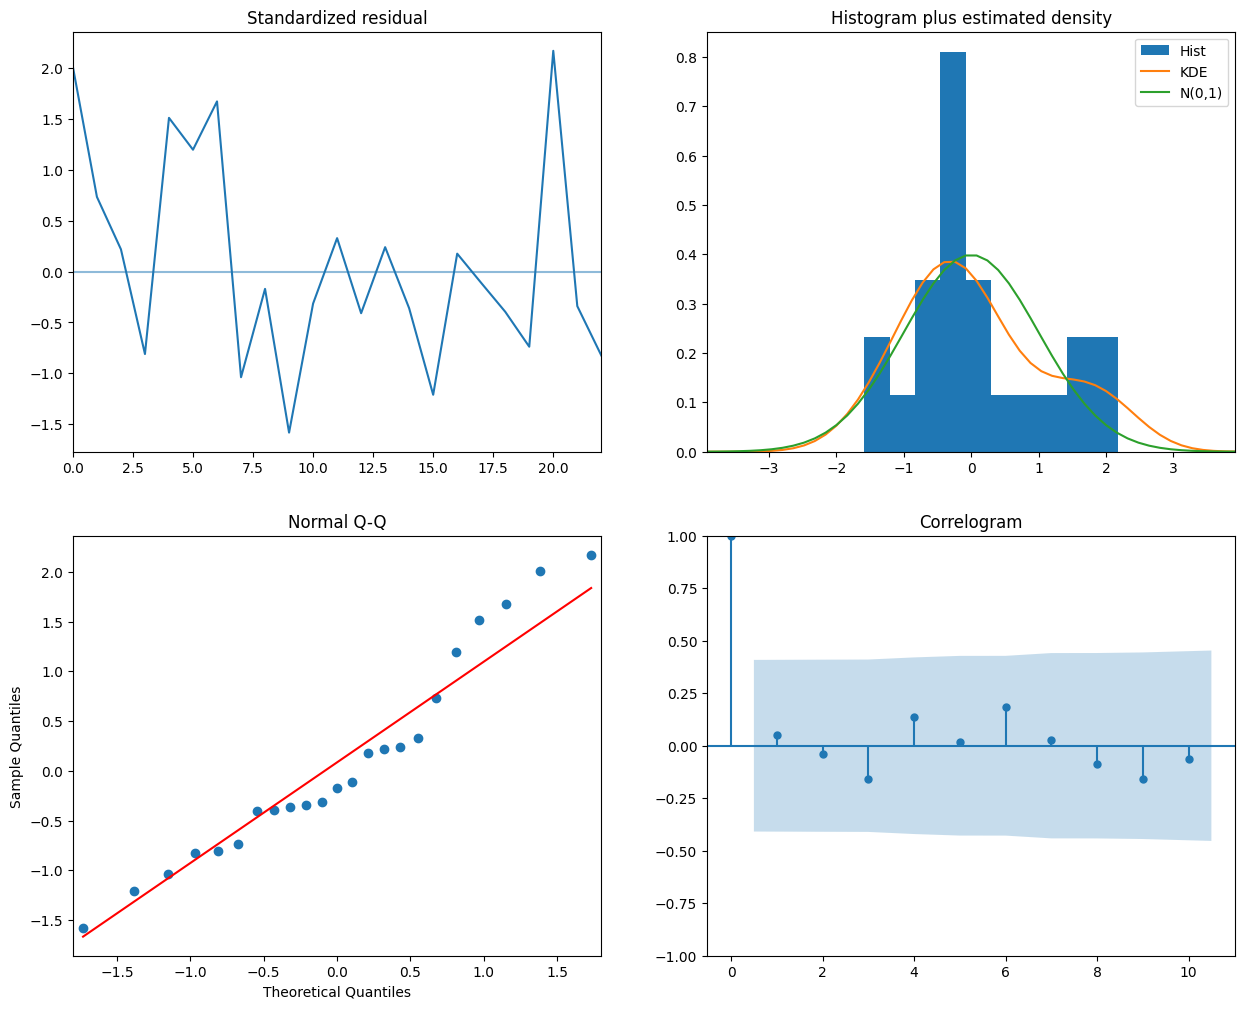

In [64]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

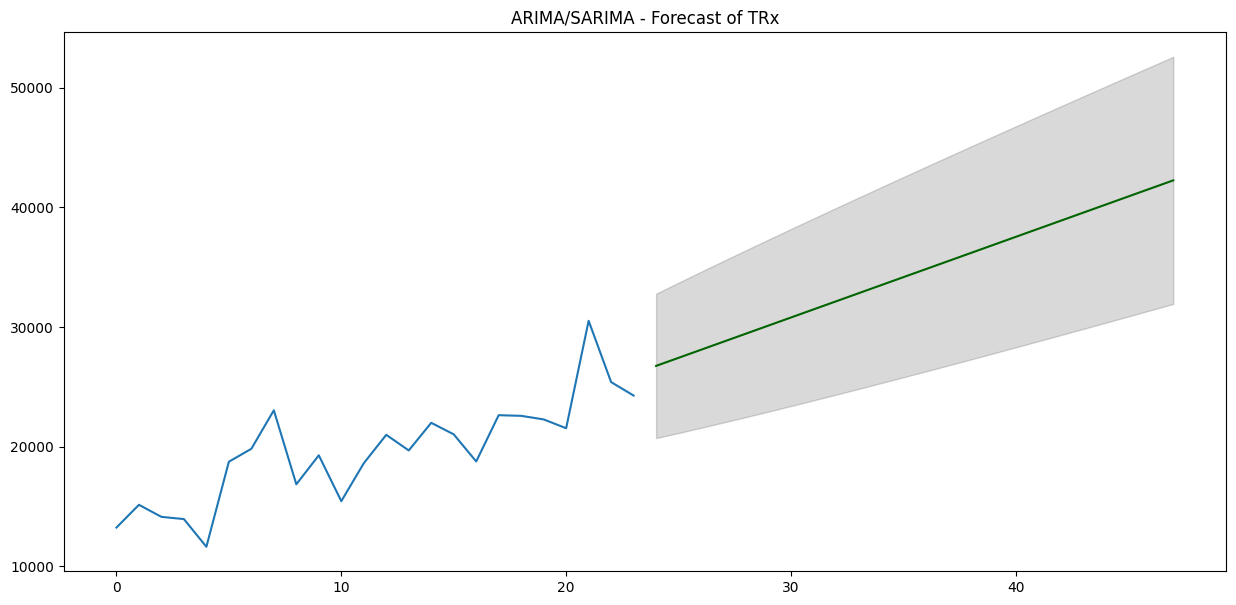

In [65]:
def forecast(ARIMA_model, periods):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.Series(range(final_dataset.index[-1]+1 , final_dataset.index[-1]+1 + periods))

 # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(final_dataset['TRX'], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of TRx")
    plt.show()

forecast(ARIMA_model,24)

We have used the model to forecast TRx over the next 24 months.

As we can see from the plot above, this doesn’t seem to be a very accurate forecast beacuse it captures trend accurately but not seasonal component, Maybe we need to change the model structure so that it takes seasonality into account.

## SARIMA Model
Now let’s try the same strategy as we did above, except let’s use a SARIMA model so that we can account for seasonality.

In [66]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(final_dataset['TRX'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=0, 
                         D = 1, #order of the seasonal differencing
                         trace=False,
                         error_action='warn',  
                         suppress_warnings=False, 
                         stepwise=True)

Taking a look at the model diagnostics, we can see some significant differences when compared with the standard ARIMA model.

__Standardized residual__
The Standardized residual is much more consistent across the graph, meaning that the data is closer to being stationary.

__Histogram plus KDE estimate__
The KDE curve is similar to the normal distribution (not much changed here).

__Normal Q-Q__
The data points are clustered much closer to the line than in the ARIMA diagnostic plot.

__Correlogram (ACF plot)__
The grey area is the confidence band, and if values fall outside of this then they are statistically significant. We want all values inside this area. All the points fall within the 95% confidence interval.

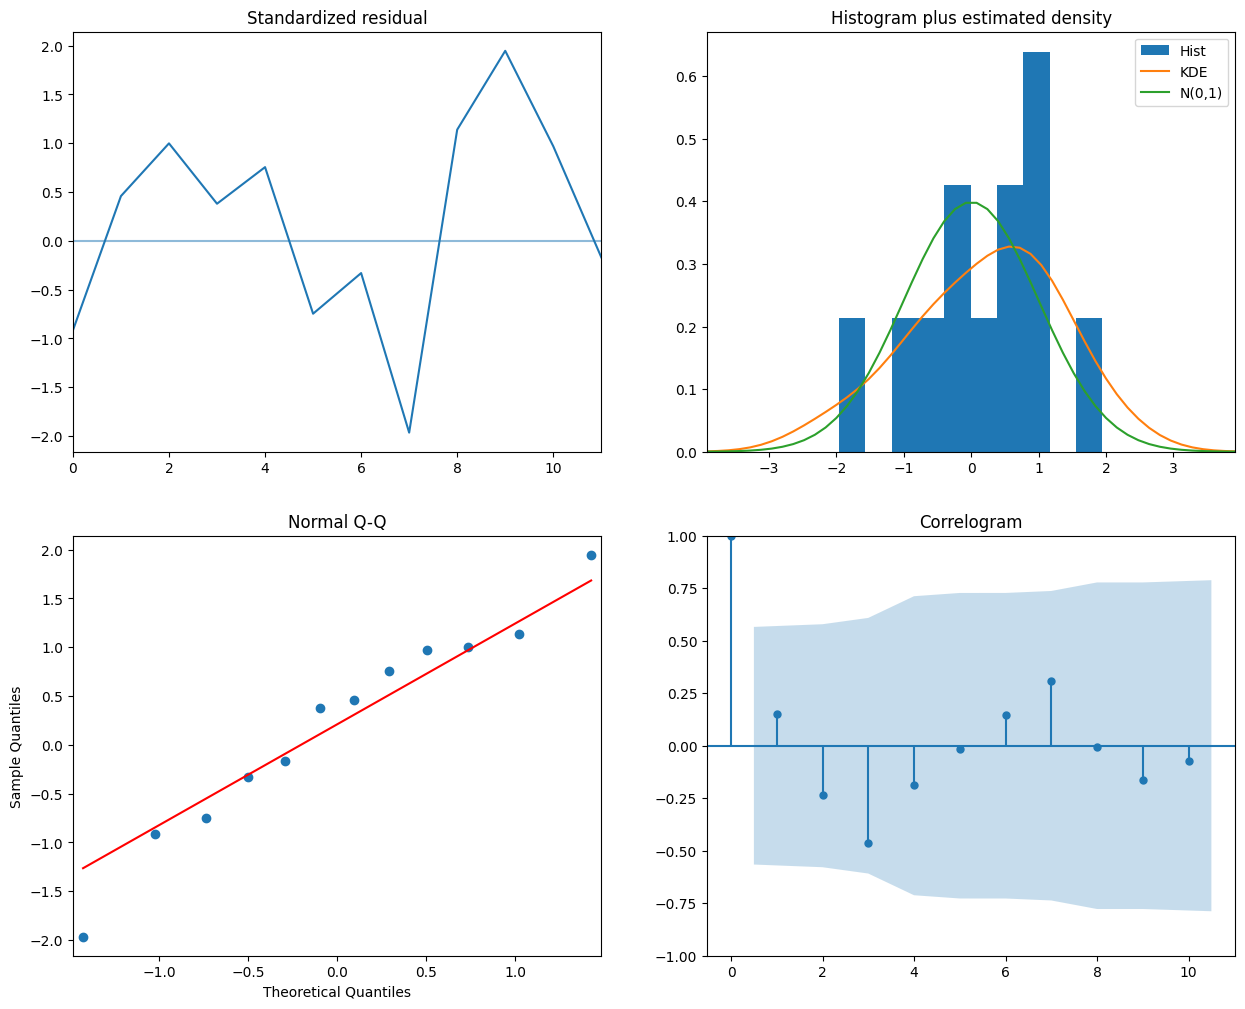

In [67]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [68]:
SARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   24
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood                -111.745
Date:                             Mon, 02 Sep 2024   AIC                            229.490
Time:                                     14:20:44   BIC                            230.945
Sample:                                          0   HQIC                           228.952
                                              - 24                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4674.4524   1327.044      3.522      0.000    2073.494    7275.411
ma.L1          0.5771      0.216      2.670      0.008       0.154       1.001
sigma2      6.367e+06   3.35e+06      1.902      0.057   -1.93e+05    1.29e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.55   Prob(JB):                         0.80
Heteroskedasticity (H):               2.76   Skew:                            -0.43
Prob(H) (two-sided):                  0.35   Kurtosis:                         2.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

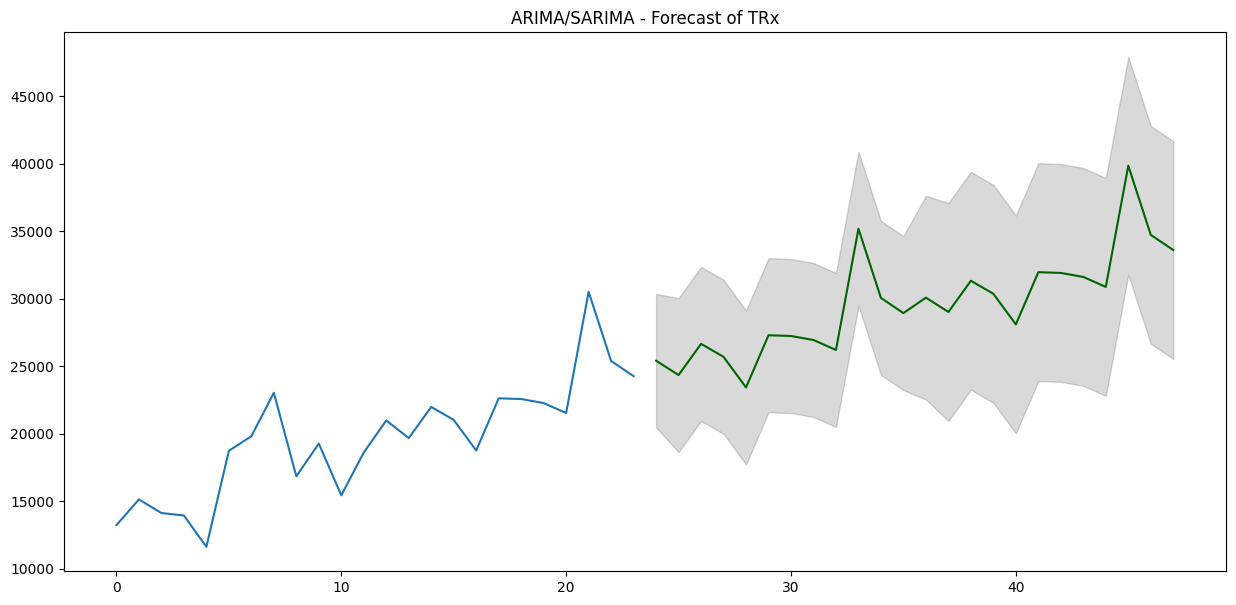

In [69]:
forecast(SARIMA_model,24)

## SARIMAX Model Selection
Now let’s check after adding in an __exogenous variable.__ For testing purpose, we are simply going to add the __month number__ as an exogenous variable, but this is not super useful as this is already conveyed through the seasonality.

Note that we are adding additional square brackets around the data being passed into the SARIMAX model.

In [71]:
#adding exogenous variable
#final_dataset['month_index'] = final_dataset.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(final_dataset[['TRX']], exogenous=final_dataset[['Month']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
get_parametes = SARIMAX_model.get_params()
print(type(get_parametes))
get_parametes

<class 'dict'>


{'maxiter': 50,
 'method': 'lbfgs',
 'order': (0, 0, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 1, 0, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

24   25411.94
25   24350.45
26   26661.45
27   25697.45
28   23429.45
29   27299.45
30   27244.45
31   26945.45
32   26208.45
33   35191.45
34   30065.45
35   28941.45
36   30086.39
37   29024.90
38   31335.90
39   30371.90
40   28103.90
41   31973.90
42   31918.90
43   31619.90
44   30882.90
45   39865.90
46   34739.90
47   33615.90
dtype: float64
24   20466.36
25   18640.33
26   20951.33
27   19987.33
28   17719.33
29   21589.33
30   21534.33
31   21235.33
32   20498.33
33   29481.33
34   24355.33
35   23231.33
36   22532.30
37   20949.57
38   23260.57
39   22296.57
40   20028.57
41   23898.57
42   23843.57
43   23544.57
44   22807.57
45   31790.57
46   26664.57
47   25540.57
dtype: float64
24   30357.52
25   30060.58
26   32371.58
27   31407.58
28   29139.58
29   33009.58
30   32954.58
31   32655.58
32   31918.58
33   40901.58
34   35775.58
35   34651.58
36   37640.48
37   37100.24
38   39411.24
39   38447.24
40   36179.24
41   40049.24
42   39994.24
43   39695.24
44   38958.24
45  

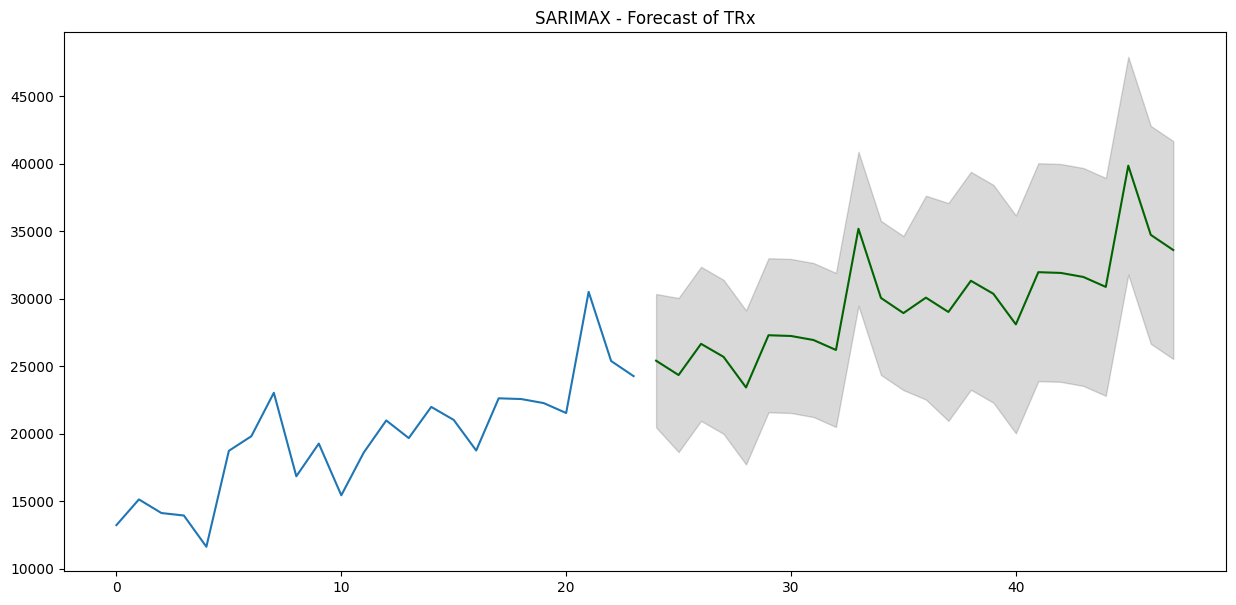

In [72]:
def sarimax_forecast(SARIMAX_model, periods):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(final_dataset.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.Series(range(final_dataset.index[-1]+1 , final_dataset.index[-1]+1 + periods)))
    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.Series(range(final_dataset.index[-1]+1 , final_dataset.index[-1]+1 + periods))

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    
    print(fitted_series)
    print(lower_series)
    print(upper_series)
    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(final_dataset['TRX'], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of TRx")
    plt.show()
    
sarimax_forecast(SARIMAX_model, 24)


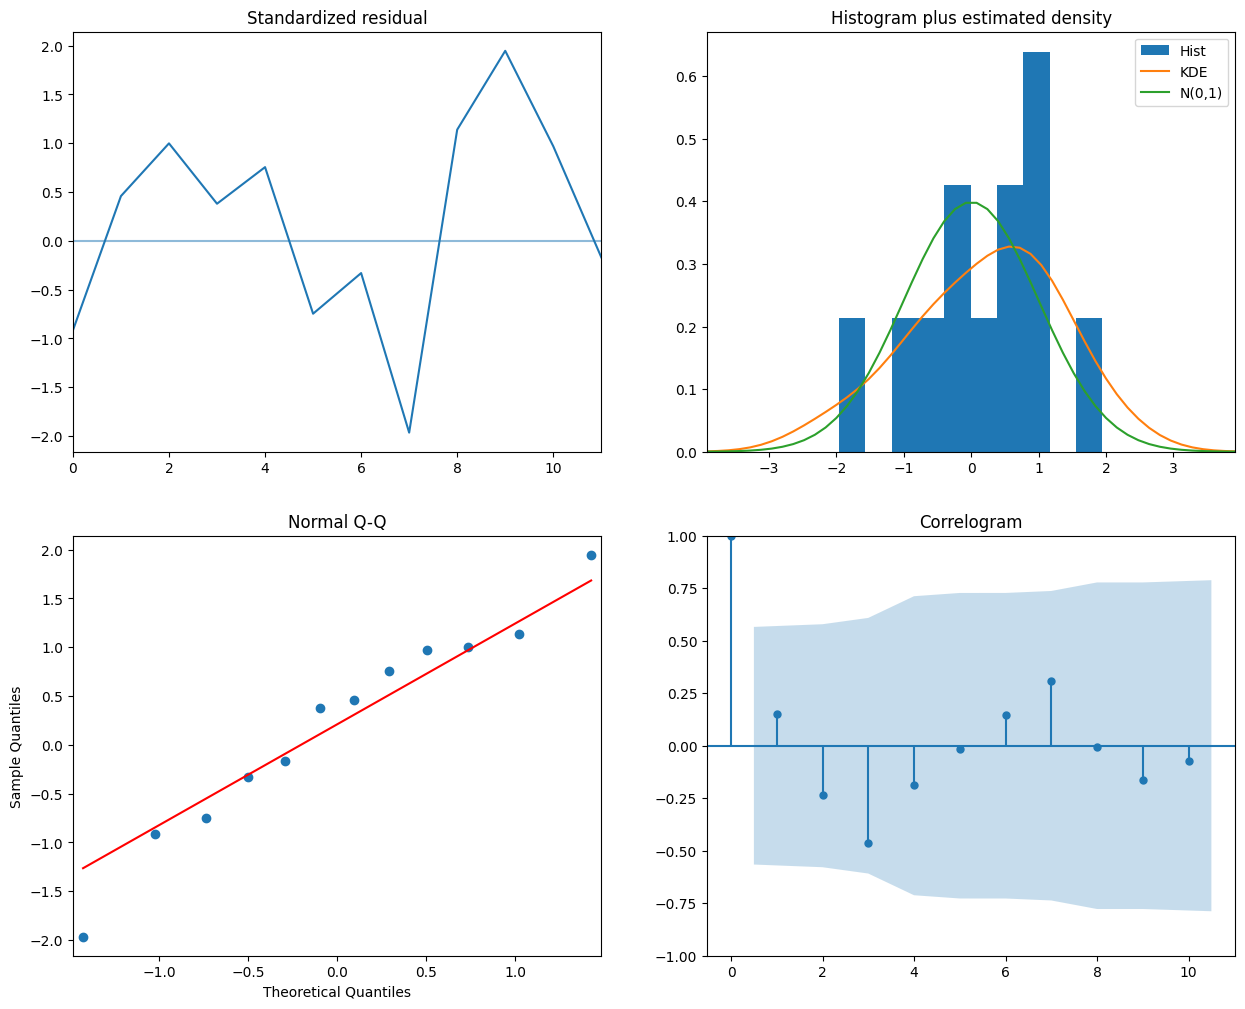

In [73]:
SARIMAX_model.plot_diagnostics(figsize=(15,12))
plt.show()

### Generating forecasted values for all brands and region wise

In [74]:
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings("ignore")
brand_unique_values = grouped_data['BRAND'].unique()
region_unique_values = grouped_data['REGION'].unique()
forcasted_values = []
n_periods = 25
for brand_i in brand_unique_values:
    for region_i in region_unique_values:
        data = grouped_data[(grouped_data['BRAND']  == brand_i ) & (grouped_data['REGION'] == region_i)]
        brand_wise_data = data[['TRX']].reset_index(drop = True)
        brand_wise_data['Month'] = brand_wise_data.index+24
        arima_4 = ARIMA(brand_wise_data['TRX'][0:], order=(1,0,0))
        SARIMAX_model = pm.auto_arima(brand_wise_data[['TRX']], exogenous=brand_wise_data['Month'],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
        fitted, confint = SARIMAX_model.predict(n_periods=n_periods, return_conf_int=True)
        index_of_fc = pd.Series(range(brand_wise_data.index[-1] , brand_wise_data.index[-1] + n_periods))

# make series for plotting purpose
        fitted_series = pd.Series(fitted, index=index_of_fc)
        lower_series = pd.Series(confint[:, 0], index=index_of_fc)
        upper_series = pd.Series(confint[:, 1], index=index_of_fc)
        ts_decompose_multiplicative = seasonal_decompose(fitted, model = 'multiplicative', period=12, extrapolate_trend = 'freq')
        ts_decompose_additive = seasonal_decompose(fitted, model = 'additive', period=12, extrapolate_trend = 'freq')
        forcasted_values.append([fitted,lower_series,upper_series, brand_i , region_i,ts_decompose_multiplicative.seasonal, ts_decompose_multiplicative.trend, ts_decompose_multiplicative.resid])

In [75]:
forecasted_data = pd.DataFrame(columns=['BRAND','REGION','MONTH','FORECASTED_TRx','SEASONAL_COMPONENT','MULTIPLICATIVE_TREND','RESIDUAL','CONFIDENCE_INTERVAL_UPPER','CONFIDENCE_INTERVAL_LOWER'])
 
 
for j in range(len(forcasted_values)):
    for i in range(len(forcasted_values[j][0])):
        forecasted_data.loc[len(forecasted_data.index)] = [forcasted_values[j][3], forcasted_values[j][4], 25+i ,list(forcasted_values[j][0])[i],list(forcasted_values[j][5])[i],list(forcasted_values[j][6])[i],list(forcasted_values[j][7])[i],list(forcasted_values[j][2])[i],list(forcasted_values[j][1])[i]]

In [76]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
start_date = datetime(2024, 8 ,1)
forecasted_data.loc[:,'DATE'] = forecasted_data.loc[:,'MONTH'].apply(lambda x: start_date + relativedelta(months = x-24))

In [86]:
file = 'Pharmaceutical_brand_predictive_SARIMAX.csv'
forecasted_data.to_csv(file , index=False)

In [87]:
forecasted_data

,BRAND,REGION,MONTH,FORECASTED_TRx,SEASONAL_COMPONENT,MULTIPLICATIVE_TREND,RESIDUAL,CONFIDENCE_INTERVAL_UPPER,CONFIDENCE_INTERVAL_LOWER,DATE
0,BETAVAX,Mid-Atlantic,25,7125.08,0.91,8010.38,0.98,9153.91,5096.26,2024-09-01
1,BETAVAX,Mid-Atlantic,26,7881.08,0.97,8122.22,1.00,9909.91,5852.26,2024-10-01
2,BETAVAX,Mid-Atlantic,27,7858.08,0.96,8234.06,0.99,9886.91,5829.26,2024-11-01
3,BETAVAX,Mid-Atlantic,28,7389.08,0.90,8345.90,0.99,9417.91,5360.26,2024-12-01
4,BETAVAX,Mid-Atlantic,29,7725.08,0.92,8457.74,0.99,9753.91,5696.26,2025-01-01
...,...,...,...,...,...,...,...,...,...,...
695,ZETAPHIN,West,45,34516.67,0.81,41499.36,1.02,39351.17,29682.17,2026-05-01
696,ZETAPHIN,West,46,44642.67,1.07,42103.64,0.99,49477.17,39808.17,2026-06-01
697,ZETAPHIN,West,47,40784.67,0.95,42707.92,1.01,45619.17,35950.17,2026-07-01
698,ZETAPHIN,West,48,44795.67,1.04,43312.19,1.00,49630.17,39961.17,2026-08-01


      BRAND        REGION  MONTH  FORECASTED_TRx  SEASONAL_COMPONENT   
0   BETAVAX  Mid-Atlantic     25         7125.08                0.91  \
1   BETAVAX  Mid-Atlantic     26         7881.08                0.97   
2   BETAVAX  Mid-Atlantic     27         7858.08                0.96   
3   BETAVAX  Mid-Atlantic     28         7389.08                0.90   
4   BETAVAX  Mid-Atlantic     29         7725.08                0.92   
5   BETAVAX  Mid-Atlantic     30         8683.08                1.01   
6   BETAVAX  Mid-Atlantic     31         8902.08                1.03   
7   BETAVAX  Mid-Atlantic     32         9577.08                1.09   
8   BETAVAX  Mid-Atlantic     33         7926.08                0.90   
9   BETAVAX  Mid-Atlantic     34        10483.08                1.15   
10  BETAVAX  Mid-Atlantic     35         9208.08                1.01   
11  BETAVAX  Mid-Atlantic     36        10748.08                1.16   
12  BETAVAX  Mid-Atlantic     37         8467.17                

NameError: name 'ts_decompose' is not defined

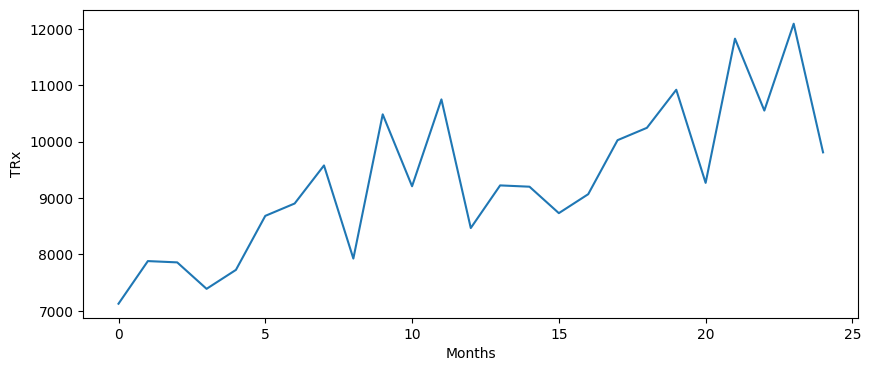

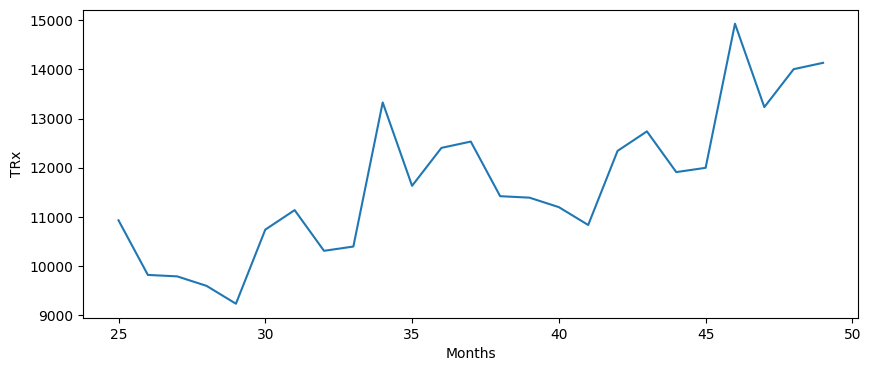

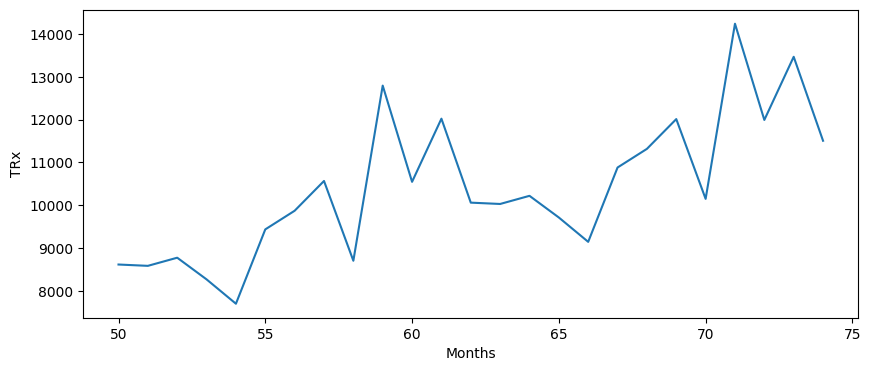

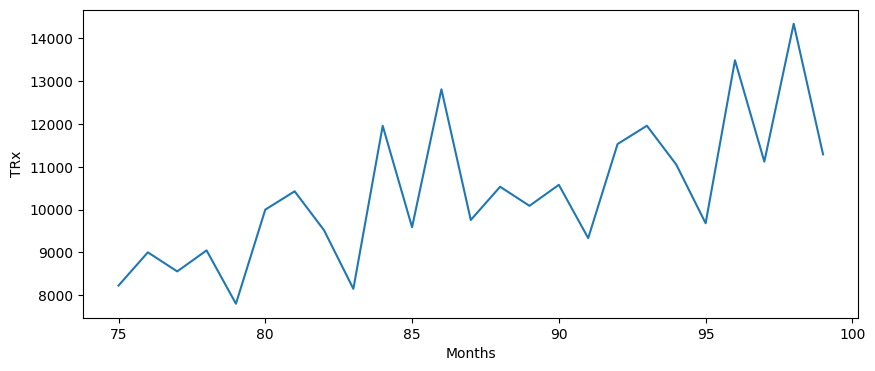

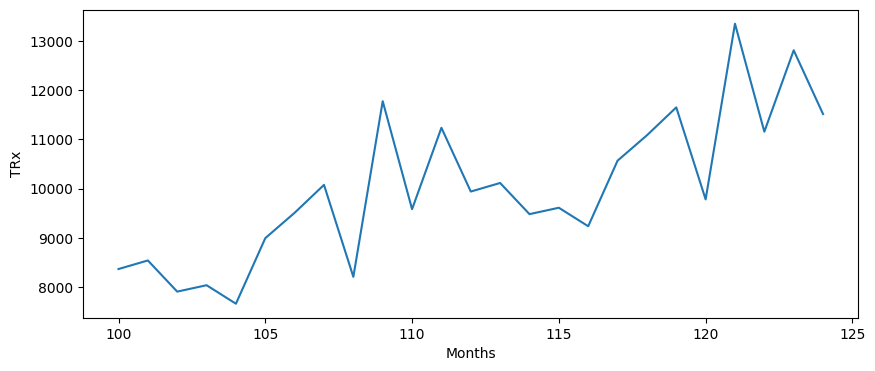

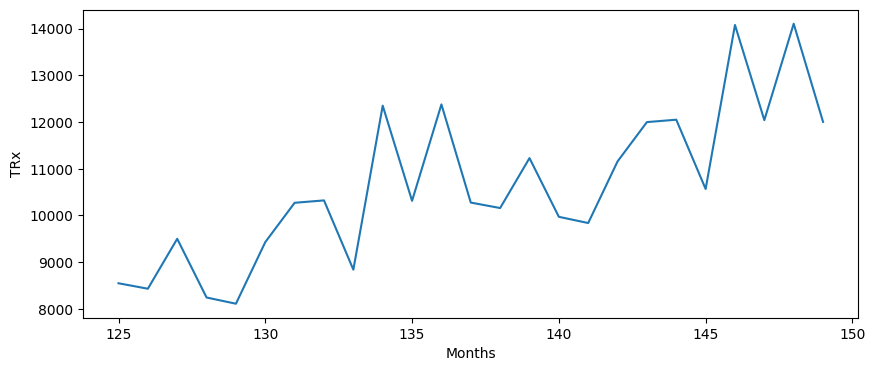

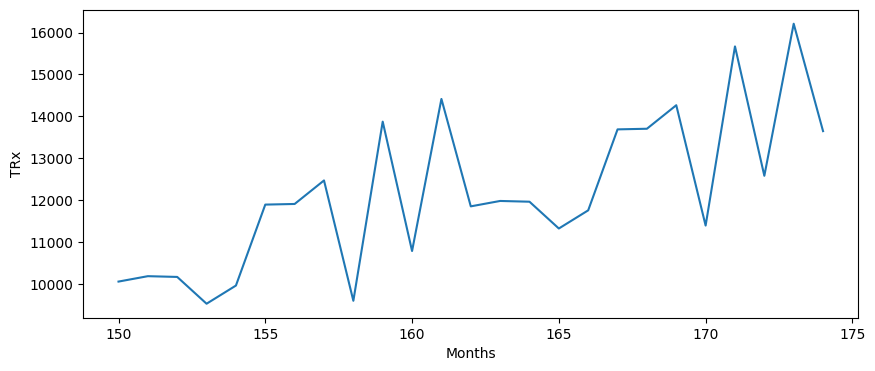

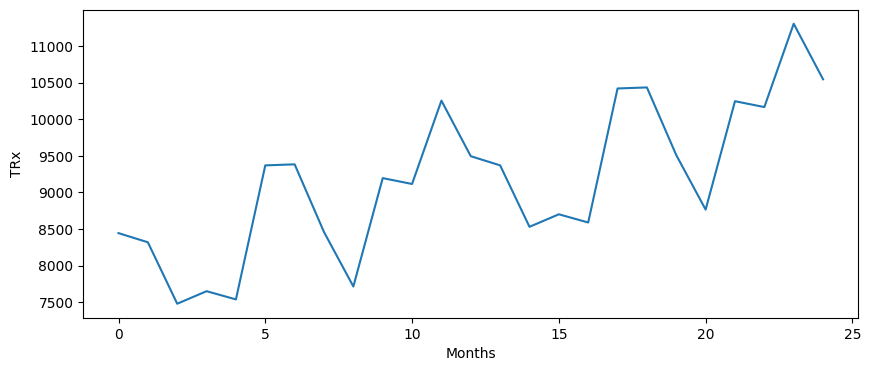

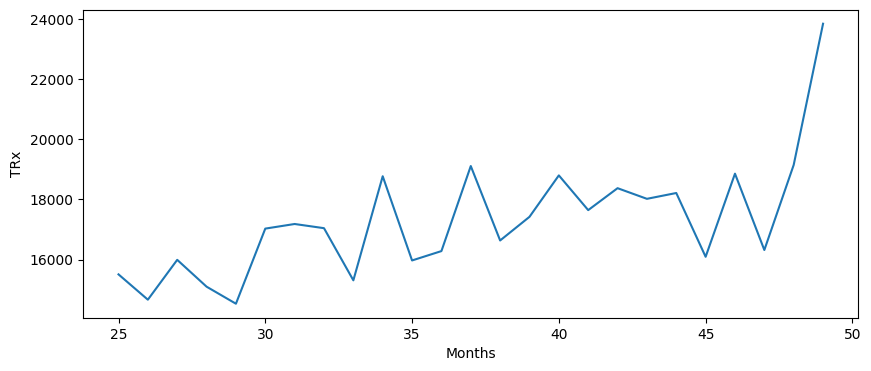

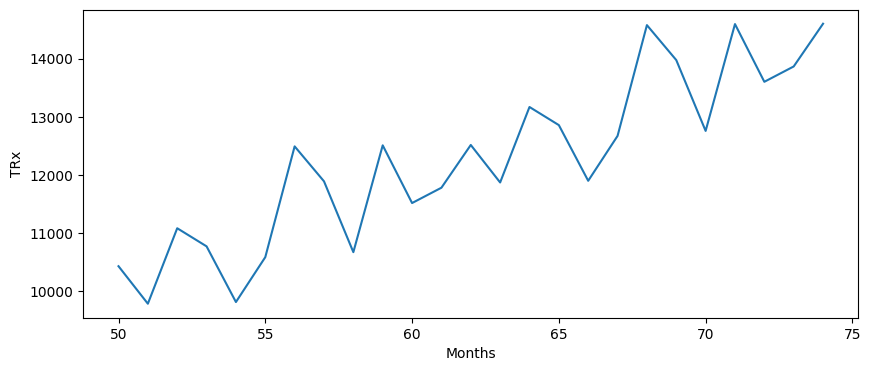

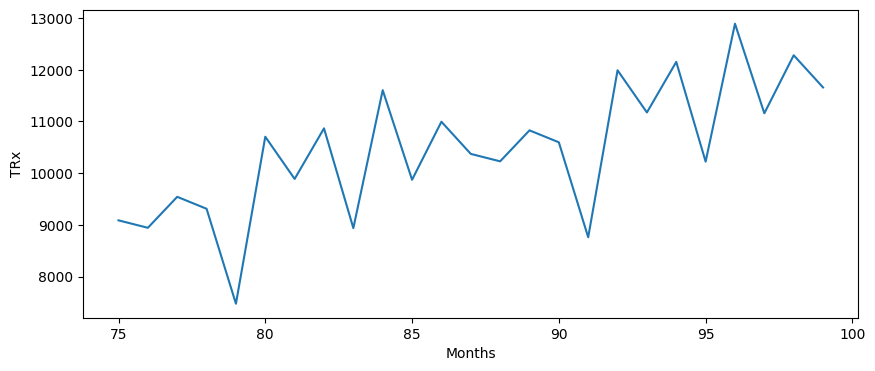

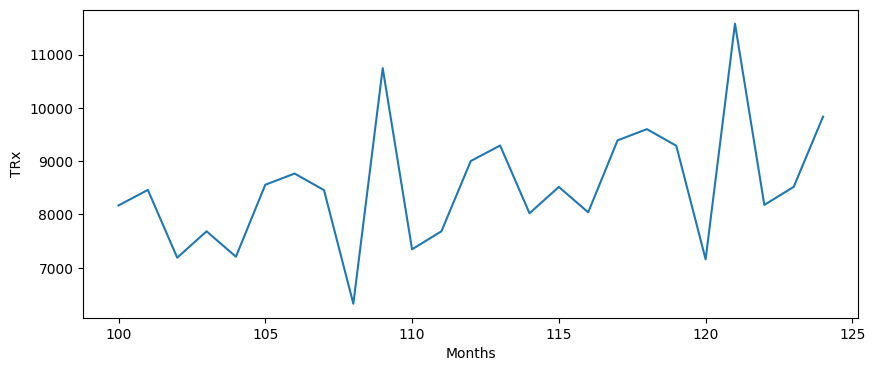

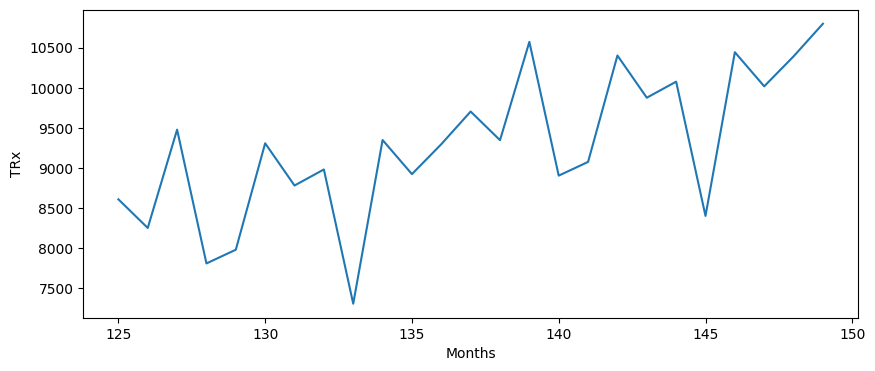

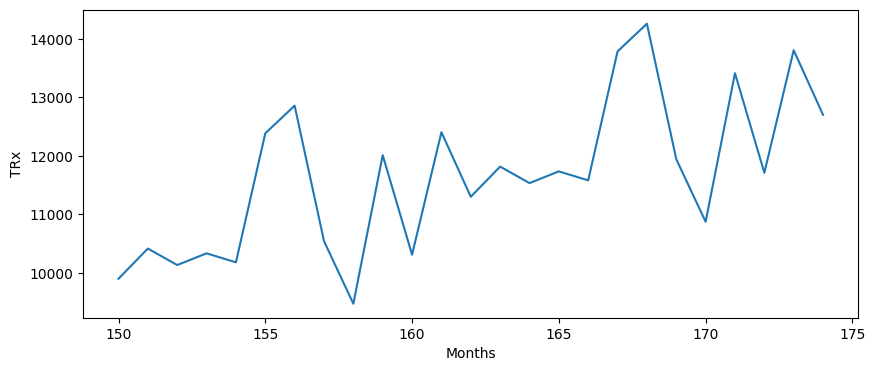

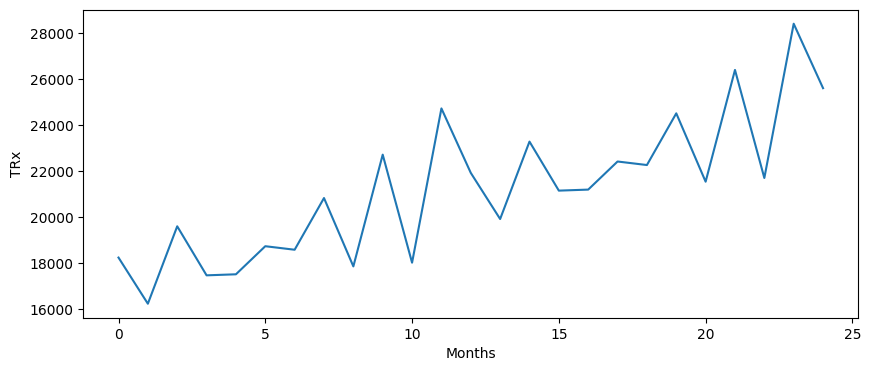

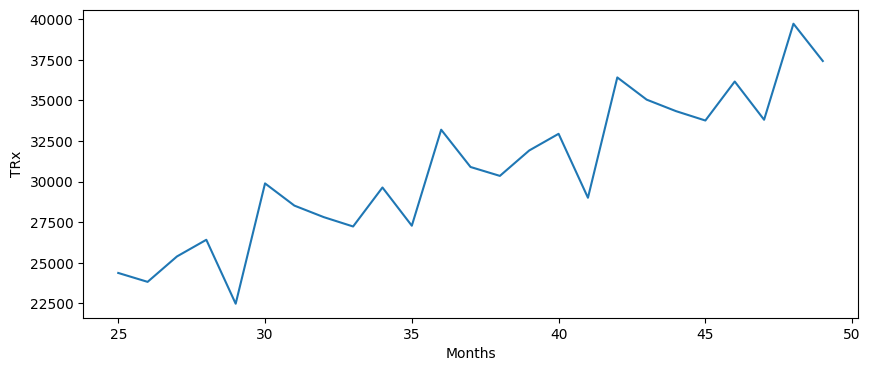

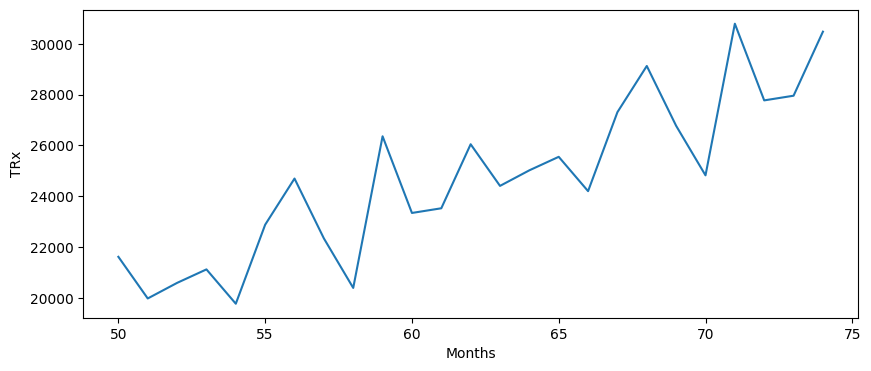

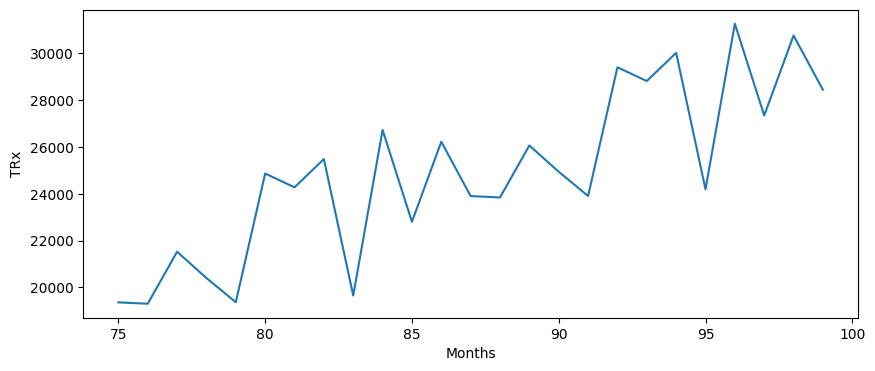

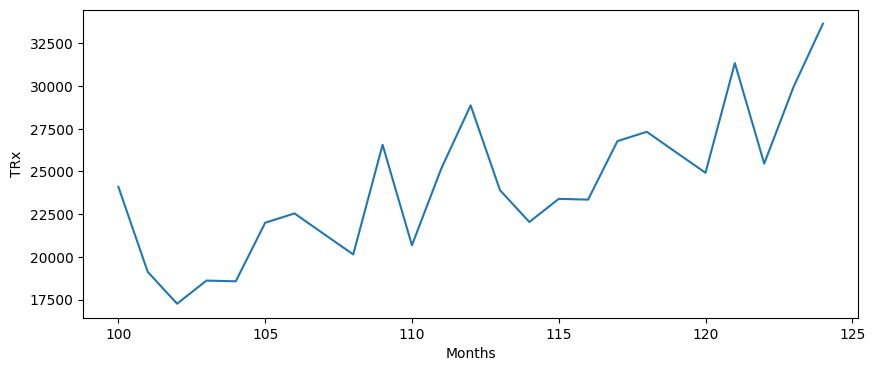

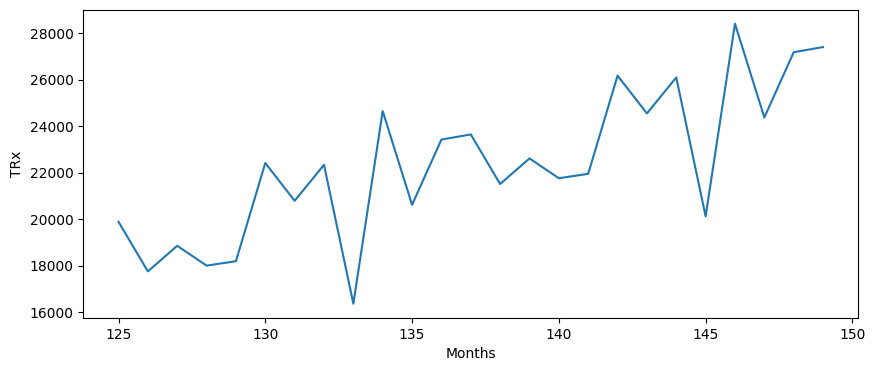

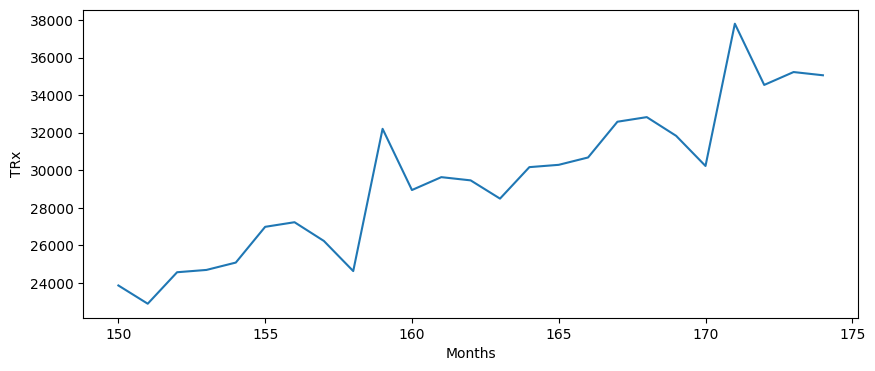

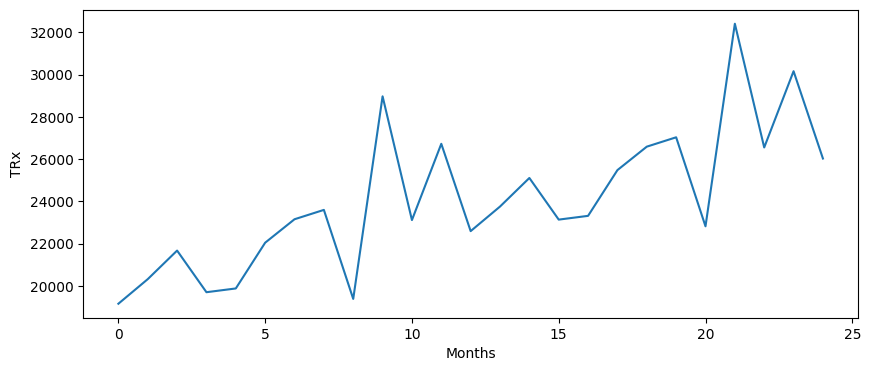

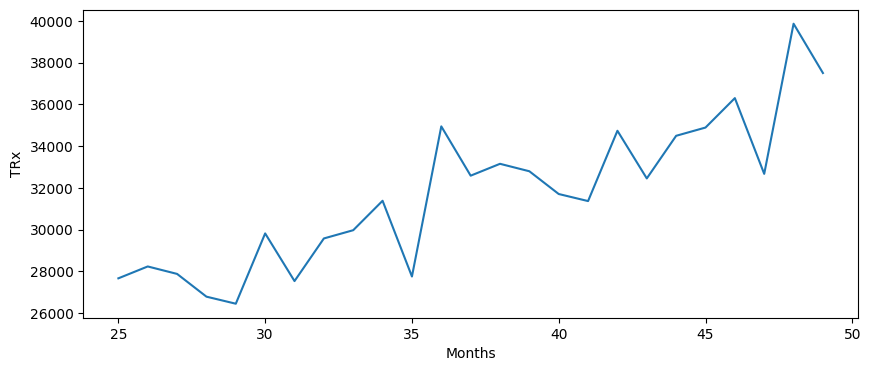

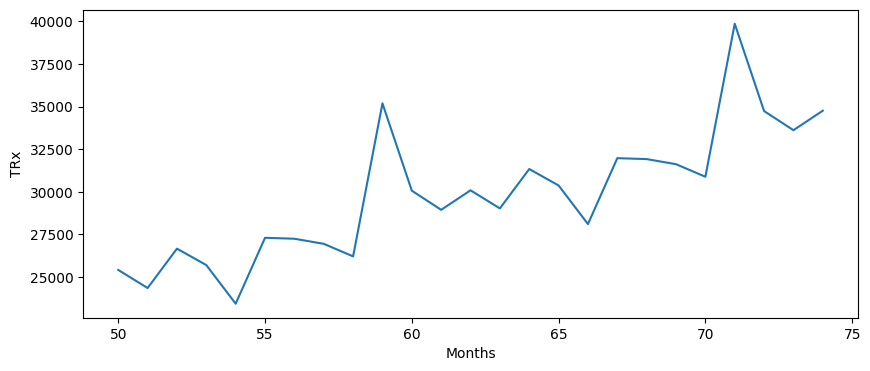

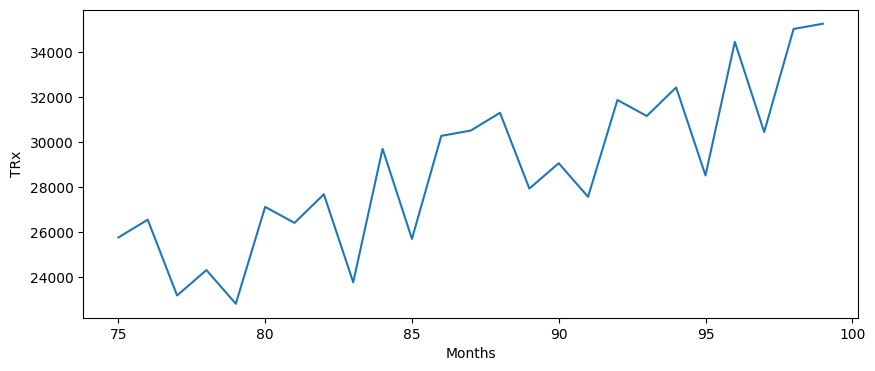

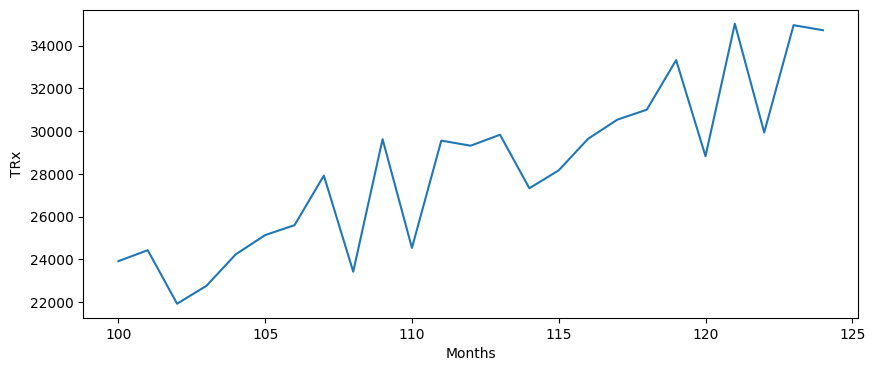

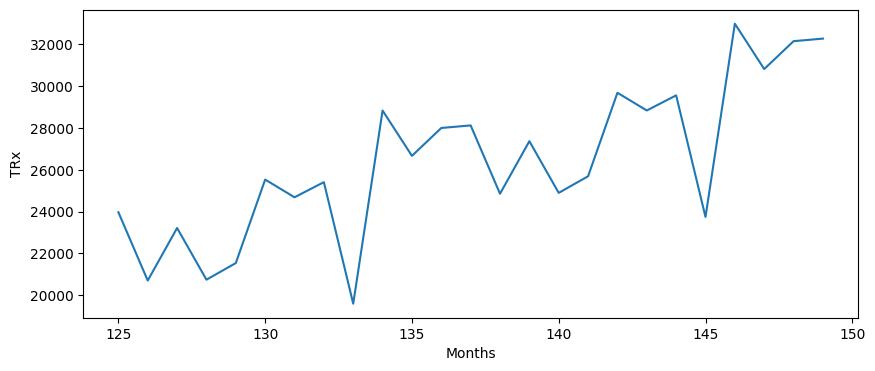

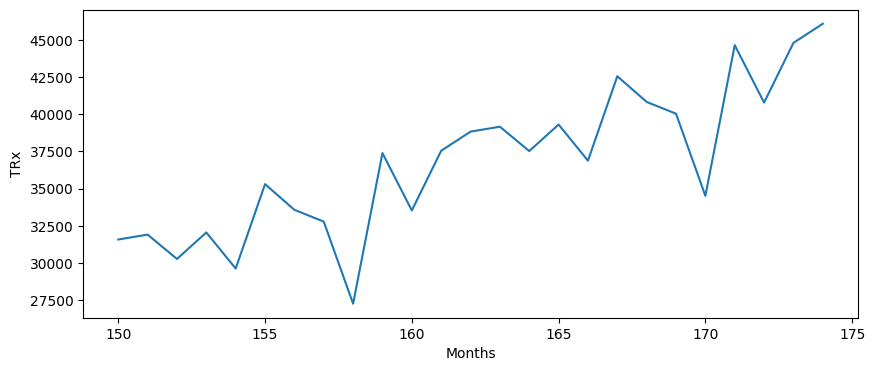

In [84]:
brand_unique_values_df = forecasted_data['BRAND'].unique()
region_unique_values_df = forecasted_data['REGION'].unique()

for brand in brand_unique_values_df:
     for region in region_unique_values_df:
         filtered_df_1 = forecasted_data[forecasted_data['BRAND'] == brand].reset_index(drop = True)
         filtered_df = filtered_df_1[filtered_df_1['REGION'] == region]
         print(filtered_df)
         plt.figure(figsize=(10,4))
         plt.xlabel("Months")
         plt.ylabel("TRx")
         plt.plot(filtered_df['FORECASTED_TRx'])
         ts_decompose_multiplicative = seasonal_decompose(filtered_df['FORECASTED_TRx'], model = 'multiplicative', period=12, extrapolate_trend = 'freq')
         ts_decompose_additive = seasonal_decompose(filtered_df['FORECASTED_TRx'], model = 'additive', period=12, extrapolate_trend = 'freq')
 #Plotting 
ts_decompose.show()
ts_plot = ts_decompose_multiplicative.plot()
ts_plot = ts_decompose_additive.plot() 

In [85]:
#from refractio import snowflake
#snowflake.get_connection()
#snowflake.execute_query(f"PUT file://{file} @PHARMACEUTICAL_BRAND.PUBLIC.PHARMA_BRAND_STAGE")

Exception occurred in getting snowflake connection: HTTPConnectionPool(host='fdc-project-manager', port=80): Max retries exceeded with url: /project-manager/connections/api/ConnectionManager/v1/connection/sourceName?profile=default (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f61da817f10>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Exception occurred in getting snowflake connection: HTTPConnectionPool(host='fdc-project-manager', port=80): Max retries exceeded with url: /project-manager/connections/api/ConnectionManager/v1/connection/sourceName?profile=default (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f61da867220>: Failed to establish a new connection: [Errno -2] Name or service not known'))
Exception occurred in execute_query: 'NoneType' object has no attribute 'cursor'


In [90]:
from fosforml import register_model

In [95]:
sf_df = my_session.createDataFrame(forecasted_data)
sf_df.write.mode("overwrite").save_as_table("Pharmaceutical_brand_predictive")
my_session.table("Pharmaceutical_brand_predictive").show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"BRAND"  |"REGION"      |"MONTH"  |"FORECASTED_TRx"    |"SEASONAL_COMPONENT"  |"MULTIPLICATIVE_TREND"  |"RESIDUAL"          |"CONFIDENCE_INTERVAL_UPPER"  |"CONFIDENCE_INTERVAL_LOWER"  |"DATE"               |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|BETAVAX  |Mid-Atlantic  |25       |7125.083333333334   |0.9058167215010005    |8010.3784722222235      |0.9819662887577324  |9153.907283565146            |5096.259383101523            |2024-09-01 00:00:00  |
|BETAVAX  |Mid-Atlantic  |26       |7881.083333333334   |0.9743556006395913    |8122.218750000002       |0.9958495970857327  |9909.907283565146            |5852.259